# Notebook for data analysis
## - uses dataframes from 'sensory' and 'projection' sessions (see ia_dataframe_basic.ipynb or ia_dataframe_derivative.ipynb)
## - plotting from dataframes (see ia_dataframe_basic.ipynb)

In [2]:
%run ./rob_setup_notebook.ipynb

import utils.utils_funcs as uf
import utils.gsheets_importer as gsi
import utils.ia_funcs as ia 
from utils.paq2py import *

session_type = 'sensory_2sec_test'
# 'sensory_nodetrend'
# 'sensory_highactivity'
# 'sensory_topactivity'
# 'sensory_topcells'
# 'sensory_extremefilter'
# 'sensory_responsivecells'
# 'sensory_2sec_test'
# 'projection_nodetrend'
# 'projection_2sec_test'
# 'interneuron'

plot_lw = 3
patch_color = '0.9'

projection = True if 'projection' in session_type else False
sensory = True if 'sensory' in session_type else False
interneuron = True if 'interneuron' in session_type else False

if sensory:
    plot_colors = ['steelblue', 'darkorange', 'mediumseagreen']
    plot_labels = ['Random', 'Sensory', 'Sham']
    photostim_duration = 0.35
    patch_size = 0.4
    
if projection:
    plot_colors = ['sienna', 'mediumpurple', 'mediumseagreen']
    plot_labels = ['Not S2-projecting', 'S2-projecting', 'Sham']
    photostim_duration = 0.35
    patch_size = 0.4

if interneuron:
    plot_colors = ['steelblue', 'mediumseagreen']
    plot_labels = ['Random', 'Sham']
    photostim_duration = 0.2
    patch_size = 0.3

fig_dir = os.path.join(fig_save_path, 'S1S2_mechanisms_panels', '')
fig_save_path = os.path.join(fig_save_path, 'S1S2_mechanisms_panels', session_type)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Suite2p path: ['/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/suite2p']
qnap_path: /home/rlees/mnt/qnap 
qnap_data_path /home/rlees/mnt/qnap/Data 
pkl_folder: /home/rlees/mnt/qnap/pkl_files 
master_path: /home/rlees/mnt/qnap/master_pkl/master_obj.pkl 
fig_save_path: /home/rlees/mnt/qnap/Analysis/Figures 
stam_save_path: /home/rlees/mnt/qnap/Analysis/STA_movies 
s2_borders_path: /home/rlees/mnt/qnap/Analysis/S2_borders


# Define dataframe paths

In [3]:
session_df_path = qnap_path + '/pkl_files/dataframes/' + session_type + '_session_df.pkl'
experiment_df_path = qnap_path + '/pkl_files/dataframes/' + session_type + '_experiment_df.pkl'
trial_df_path = qnap_path + '/pkl_files/dataframes/' + session_type + '_trial_df.pkl'
cell_df_path = qnap_path + '/pkl_files/dataframes/' + session_type + '_cell_df.pkl'
cell_trial_df_path = qnap_path + '/pkl_files/dataframes/' + session_type + '_cell_trial_df.pkl'
cell_mean_timepoint_df_path = qnap_path + '/pkl_files/dataframes/' + session_type + '_cell_mean_timepoint_df.pkl'
cell_trial_single_timepoint_df_path = (qnap_path + '/pkl_files/dataframes/' + session_type + 
                                       '_cell_trial_single_timepoint_df.pkl')

# Load all dataframes

In [4]:
session_df = pd.read_pickle(session_df_path)
trial_df = pd.read_pickle(trial_df_path)
experiment_df = pd.read_pickle(experiment_df_path)
cell_trial_df = pd.read_pickle(cell_trial_df_path)
cell_df = pd.read_pickle(cell_df_path)
cell_mean_timepoint_df = pd.read_pickle(cell_mean_timepoint_df_path)
cell_trial_single_timepoint_df = pd.read_pickle(cell_trial_single_timepoint_df_path)

In [5]:
if sensory:
    remove_list = ['2020-09-15_RL102', '2020-09-09_RL100']
    for remove_id in remove_list:
        cell_df = cell_df.query('session_id != @remove_id')
        cell_mean_timepoint_df = cell_mean_timepoint_df.query('session_id != @remove_id')
        cell_trial_df = cell_trial_df.query('session_id != @remove_id')
        trial_df = trial_df.query('session_id != @remove_id')

# General analyses for all trial types

N_numbers:
n = 6 animals
n = 180 cells for Not S2-projecting targets
n = 3034 cells for Not S2-projecting non targets
n = 216 cells for S2-projecting targets
n = 3034 cells for S2-projecting non targets
n = 180 cells for Sham targets
n = 3034 cells for Sham non targets


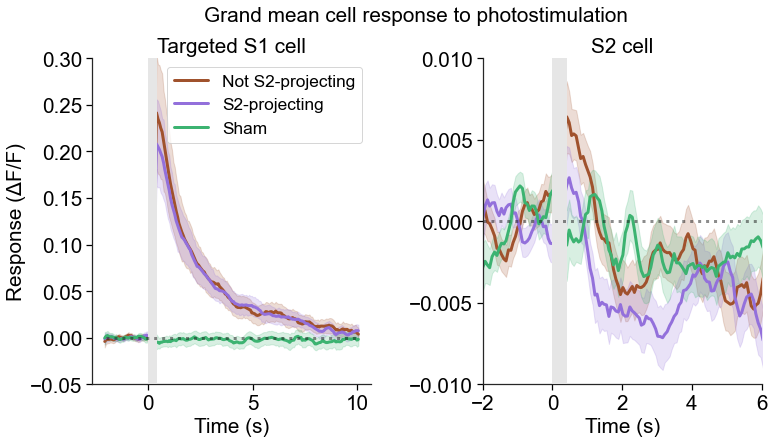

In [215]:
# GRAND AVERAGE OF ALL CELLS (POSITIVE AND NEGATIVE)

target_type = ['pr_target', 'ps_target', 'pr_target']
responses = ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(12,6))

n_numbers = []

n_numbers.append(f'n = {len(cell_df["session_id"].unique())} animals')

for label, target, response, color in zip(plot_labels, target_type, responses, plot_colors):

    # filter dataframes using variables above
    s1_targets = cell_df[cell_df[target] & cell_df['s1_cell']].index
    nontargets = cell_df[~cell_df[target] & cell_df['s2_cell']].index
    
    # populate the plots with filtered data
    for col, cell_id_list in enumerate([s1_targets, nontargets]):
        df_filter = cell_mean_timepoint_df['cell_id'].isin(cell_id_list)
        filtered_df = cell_mean_timepoint_df[df_filter].copy()
        filtered_df.loc[(filtered_df['timepoint'] > 0) & (filtered_df['timepoint'] <= photostim_duration), 
                    ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
        rolling_mean = filtered_df.groupby('cell_id').rolling(5, min_periods=1).mean()[response]
        
        ax = axes[col]
        sns.lineplot(data=filtered_df, x='timepoint', y=rolling_mean.to_numpy(), 
                     estimator='mean', ci=95, ax=ax, label=label, legend=False, color=color, linewidth=plot_lw)

        display(fig)
        clear_output(wait = True)
        
        target_text = ['targets', 'non targets']
        n_numbers.append(f'n = {len(cell_id_list.unique())} cells for {label} {target_text[col]}')
    
# construct patch to cover stim artifact period
for ax in axes:
    stim_patch = patches.Rectangle((0,-100), patch_size, 999, zorder=3, color=patch_color)
    ax.add_patch(stim_patch)

axes[0].set_title('Targeted S1 cell')
axes[1].set_title('S2 cell')

for ax in axes:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('')

axes[0].set_ylabel('Response (ΔF/F)');
axes[0].legend(plot_labels, loc='upper right');

axes[0].hlines(0, -2, 10, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);
axes[1].hlines(0, -2, 10, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);

axes[0].set_ylim([-0.05, 0.3])

if not projection:
    axes[1].set_ylim([-0.015, 0.005])
else:
    axes[1].set_ylim([-0.01, 0.01])

axes[1].set_xlim([-2, 6])

plt.subplots_adjust(wspace=0.4)
plt.suptitle('Grand mean cell response to photostimulation', fontsize='xx-large', y=1)

print('N_numbers:', *n_numbers, sep='\n')

save_path = fig_save_path + '_cell_grandaverage_dff_trace'
ia.savePlot(save_path)

N_numbers:
n = 6 animals
n = 180 cells for Not S2-projecting non targets
n = 216 cells for S2-projecting non targets
n = 180 cells for Sham non targets


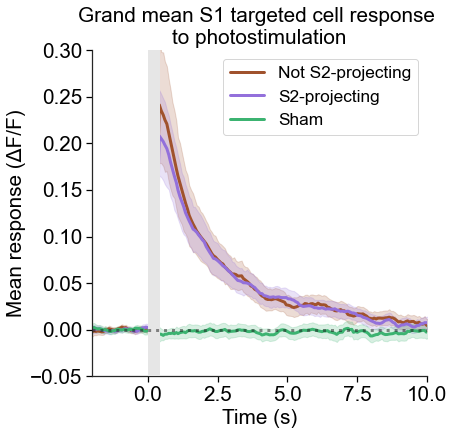

In [216]:
# GRAND AVERAGE OF ALL CELLS (POSITIVE AND NEGATIVE)

target_type = ['pr_target', 'ps_target', 'pr_target']
responses = ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, figsize=(6,6))

n_numbers = []

n_numbers.append(f'n = {len(cell_df["session_id"].unique())} animals')

for label, target, response, color in zip(plot_labels, target_type, responses, plot_colors):

    # filter dataframes using variables above
    s1_targets = cell_df[cell_df[target] & cell_df['s1_cell']].index
    
    # populate the plots with filtered data
    df_filter = cell_mean_timepoint_df['cell_id'].isin(s1_targets)
    filtered_df = cell_mean_timepoint_df[df_filter].copy()
    filtered_df.loc[(filtered_df['timepoint'] > 0) & (filtered_df['timepoint'] <= photostim_duration), 
                ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
    rolling_mean = filtered_df.groupby('cell_id').rolling(5, min_periods=1).mean()[response]

    sns.lineplot(data=filtered_df, x='timepoint', y=rolling_mean.to_numpy(), 
                 estimator='mean', ci=95, ax=ax, label=label, legend=False, color=color, linewidth=plot_lw)

    display(fig)
    clear_output(wait = True)

    n_numbers.append(f'n = {len(s1_targets.unique())} cells for {label} non targets')
    
# construct patch to cover stim artifact period
stim_patch = patches.Rectangle((0,-100), patch_size, 999, zorder=3, color=patch_color)
ax.add_patch(stim_patch)

ax.set_xlabel('Time (s)')
ax.set_ylabel('')

ax.set_ylabel('Mean response (ΔF/F)', fontname='Arial');
ax.legend(plot_labels, loc='upper right');

ax.hlines(0, -2, 10, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);

ax.set_ylim([-0.05, 0.3])

ax.set_xlim([-2, 10])

ax.set_title('Grand mean S1 targeted cell response \nto photostimulation', fontsize='xx-large', y=1)

print('N_numbers:', *n_numbers, sep='\n')

save_path = fig_save_path + '_cell_grandaverage_target_dff_trace'
ia.savePlot(save_path)

N_numbers:
n = 6 animals
n = 3034 cells for Not S2-projecting non targets
n = 3034 cells for S2-projecting non targets
n = 3034 cells for Sham non targets


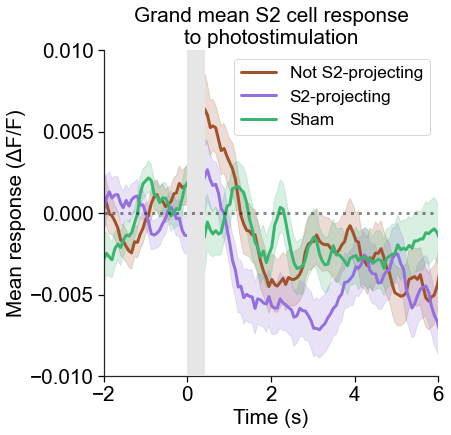

In [217]:
# GRAND AVERAGE OF ALL CELLS (POSITIVE AND NEGATIVE)

target_type = ['pr_target', 'ps_target', 'pr_target']
responses = ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, figsize=(6,6))

n_numbers = []

n_numbers.append(f'n = {len(cell_df["session_id"].unique())} animals')

for label, target, response, color in zip(plot_labels, target_type, responses, plot_colors):

    # filter dataframes using variables above
    nontargets = cell_df[~cell_df[target] & cell_df['s2_cell']].index
    
    # populate the plots with filtered data
    df_filter = cell_mean_timepoint_df['cell_id'].isin(nontargets)
    filtered_df = cell_mean_timepoint_df[df_filter].copy()
    filtered_df.loc[(filtered_df['timepoint'] > 0) & (filtered_df['timepoint'] <= photostim_duration), 
                ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
    rolling_mean = filtered_df.groupby('cell_id').rolling(5, min_periods=1).mean()[response]

    sns.lineplot(data=filtered_df, x='timepoint', y=rolling_mean.to_numpy(), 
                 estimator='mean', ci=95, ax=ax, label=label, legend=False, color=color, linewidth=plot_lw)

    display(fig)
    clear_output(wait = True)

    n_numbers.append(f'n = {len(nontargets.unique())} cells for {label} non targets')
    
# construct patch to cover stim artifact period
stim_patch = patches.Rectangle((0,-100), patch_size, 999, zorder=3, color=patch_color)
ax.add_patch(stim_patch)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Mean response (ΔF/F)');
ax.legend(plot_labels, loc='upper right');

ax.hlines(0, -2, 10, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);

if not projection:
    ax.set_ylim([-0.015, 0.005])
else:
    ax.set_ylim([-0.01, 0.01])

ax.set_xlim([-2, 6])

ax.set_title('Grand mean S2 cell response\nto photostimulation', fontsize='xx-large', y=1)

print('N_numbers:', *n_numbers, sep='\n')

save_path = fig_save_path + '_cell_grandaverage_s2_dff_trace'
ia.savePlot(save_path)

N_numbers:
n = 6 animals
n = 180 cells for Not S2-projecting targets
n = 5005 cells for Not S2-projecting non targets
n = 216 cells for S2-projecting targets
n = 4969 cells for S2-projecting non targets
n = 180 cells for Sham targets
n = 5005 cells for Sham non targets


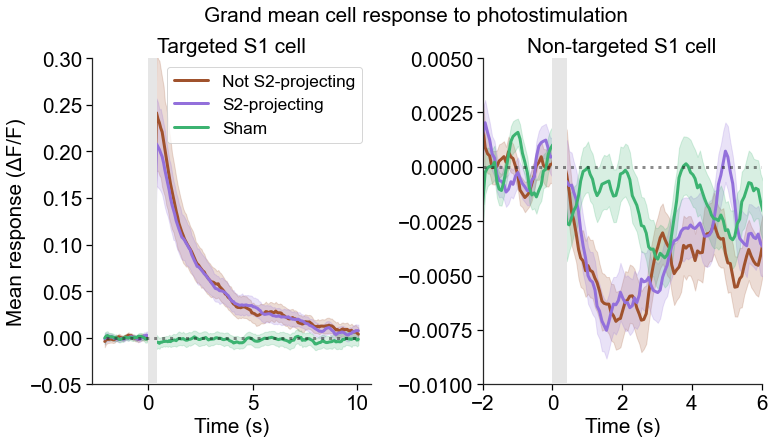

In [218]:
# GRAND AVERAGE OF ALL CELLS (POSITIVE AND NEGATIVE)

target_type = ['pr_target', 'ps_target', 'pr_target']
responses = ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(12,6))

n_numbers = []

n_numbers.append(f'n = {len(cell_df["session_id"].unique())} animals')

for label, target, response, color in zip(plot_labels, target_type, responses, plot_colors):

    # filter dataframes using variables above
    s1_targets = cell_df[cell_df[target] & cell_df['s1_cell']].index
    s2_nontargets = cell_df[~cell_df[target] & cell_df['s1_cell']].index
    
    # populate the plots with filtered data
    for col, cell_id_list in enumerate([s1_targets, s2_nontargets]):
        df_filter = cell_mean_timepoint_df['cell_id'].isin(cell_id_list)
        filtered_df = cell_mean_timepoint_df[df_filter].copy()
        filtered_df.loc[(filtered_df['timepoint'] > 0) & (filtered_df['timepoint'] <= photostim_duration), 
                ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
        rolling_mean = filtered_df.groupby('cell_id').rolling(5, min_periods=1).mean()[response]
    
        ax = axes[col]
        sns.lineplot(data=filtered_df, x='timepoint', y=rolling_mean.to_numpy(), 
                     estimator='mean', ci=95, ax=ax, label=label, legend=False, color=color, linewidth=plot_lw)

        display(fig)
        clear_output(wait = True)
        
        target_text = ['targets', 'non targets']
        n_numbers.append(f'n = {len(cell_id_list.unique())} cells for {label} {target_text[col]}')
    
# construct patch to cover stim artifact period
for ax in axes:
    stim_patch = patches.Rectangle((0,-100), patch_size, 999, zorder=3, color=patch_color)
    ax.add_patch(stim_patch)

axes[0].set_title('Targeted S1 cell')
axes[1].set_title('Non-targeted S1 cell')

for ax in axes:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('')

axes[0].set_ylabel('Mean response (ΔF/F)');
axes[0].legend(plot_labels, loc='upper right');

axes[0].hlines(0, -2, 10, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);
axes[1].hlines(0, -2, 10, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);

if not projection:
    axes[0].set_ylim([-0.05, 0.3])
    axes[1].set_ylim([-0.01, 0.005])
else:
    axes[0].set_ylim([-0.05, 0.3])
    axes[1].set_ylim([-0.01, 0.005])

axes[1].set_xlim([-2, 6])

plt.subplots_adjust(wspace=0.4)
plt.suptitle('Grand mean cell response to photostimulation', fontsize='xx-large', y=1)

print('N_numbers:', *n_numbers, sep='\n')

save_path = fig_save_path + '_cell_grandaverage_target_s1nt_dff_trace'
ia.savePlot(save_path)

N_numbers:
n = 6 animals
n = 5005 cells for Not S2-projecting non targets
n = 4969 cells for S2-projecting non targets
n = 5005 cells for Sham non targets


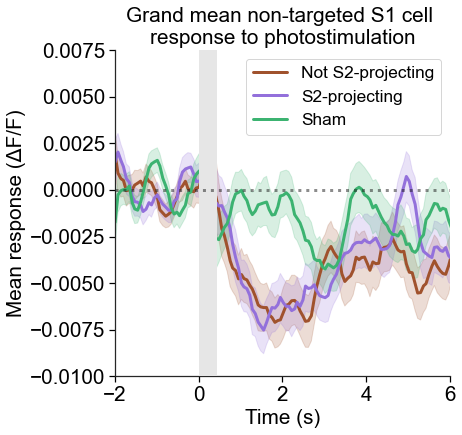

In [219]:
# GRAND AVERAGE OF ALL CELLS (POSITIVE AND NEGATIVE)

target_type = ['pr_target', 'ps_target', 'pr_target']
responses = ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, figsize=(6,6))

n_numbers = []

n_numbers.append(f'n = {len(cell_df["session_id"].unique())} animals')

for label, target, response, color in zip(plot_labels, target_type, responses, plot_colors):

    # filter dataframes using variables above
    nontargets = cell_df[~cell_df[target] & cell_df['s1_cell']].index
    
    # populate the plots with filtered data
    df_filter = cell_mean_timepoint_df['cell_id'].isin(nontargets)
    filtered_df = cell_mean_timepoint_df[df_filter].copy()
    filtered_df.loc[(filtered_df['timepoint'] > 0) & (filtered_df['timepoint'] <= photostim_duration), 
                ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
    rolling_mean = filtered_df.groupby('cell_id').rolling(5, min_periods=1).mean()[response]

    sns.lineplot(data=filtered_df, x='timepoint', y=rolling_mean.to_numpy(), 
                 estimator='mean', ci=95, ax=ax, label=label, legend=False, color=color, linewidth=plot_lw)

    display(fig)
    clear_output(wait = True)

    n_numbers.append(f'n = {len(nontargets.unique())} cells for {label} non targets')
    
# construct patch to cover stim artifact period
stim_patch = patches.Rectangle((0,-100), patch_size, 999, zorder=3, color=patch_color)
ax.add_patch(stim_patch)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Mean response (ΔF/F)');
ax.legend(plot_labels, loc='upper right');

ax.hlines(0, -2, 10, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);

if not projection:
    ax.set_ylim([-0.015, 0.005])
else:
    ax.set_ylim([-0.01, 0.0075])

ax.set_xlim([-2, 6])

ax.set_title('Grand mean non-targeted S1 cell \nresponse to photostimulation', fontsize='xx-large', y=1)

print('N_numbers:', *n_numbers, sep='\n')

save_path = fig_save_path + '_cell_grandaverage_s1nt_dff_trace'
ia.savePlot(save_path)

N_numbers:
n = 6 animals
n = 115 cells for Not S2-projecting targets
n = 1 cells for Not S2-projecting non targets
n = 132 cells for S2-projecting targets
n = 2 cells for S2-projecting non targets
n = 4 cells for Sham targets
n = 1 cells for Sham non targets


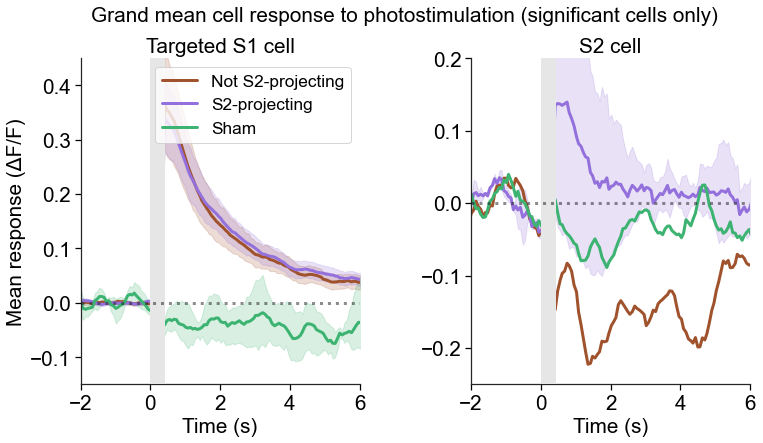

In [220]:
# GRAND AVERAGE FOR CELLS PASSING STATISTICAL TEST

test_type = 'fdr'
if test_type == 'fdr':
    stat_test = ['sta_sig_pr', 'sta_sig_ps', 'sta_sig_spont']
if test_type == 'nomulti':
    stat_test = ['sta_sig_nomulti_pr', 'sta_sig_nomulti_ps', 'sta_sig_nomulti_spont']
target_type = ['pr_target', 'ps_target', 'pr_target']
responses = ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(12,6))

n_numbers = []

n_numbers.append(f'n = {len(cell_df["session_id"].unique())} animals')

for test, label, target, response, color in zip(stat_test, plot_labels, target_type, responses, plot_colors):

    # filter dataframes using variables above
    s1_targets = cell_df[cell_df[test] & cell_df[target] & cell_df['s1_cell']].index
    s2_nontargets = cell_df[cell_df[test] & ~cell_df[target] & cell_df['s2_cell']].index
    
    # populate the plots with filtered data
    for col, cell_id_list in enumerate([s1_targets, s2_nontargets]):
        df_filter = cell_mean_timepoint_df['cell_id'].isin(cell_id_list)
        filtered_df = cell_mean_timepoint_df[df_filter].copy()
        filtered_df.loc[(filtered_df['timepoint'] > 0) & (filtered_df['timepoint'] <= photostim_duration), 
                ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
        rolling_mean = filtered_df.groupby('cell_id').rolling(5, min_periods=1).mean()[response]
    
        ax = axes[col]
        sns.lineplot(data=filtered_df, x='timepoint', y=rolling_mean.to_numpy(), 
                     estimator='mean', ci=95, ax=ax, label=label, legend=False, color=color, linewidth=plot_lw)

        display(fig)
        clear_output(wait = True)
        
        n_numbers.append(f'n = {len(cell_id_list.unique())} cells for {label} {target_text[col]}')

axes[0].set_title('Targeted S1 cell')
axes[1].set_title('S2 cell')

# construct patch to cover stim artifact period
for ax in axes:
    stim_patch = patches.Rectangle((0,-100), patch_size, 999, zorder=3, color=patch_color)
    ax.add_patch(stim_patch)
    
for ax in axes:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('')

axes[0].set_ylabel('Mean response (ΔF/F)');
axes[0].legend(plot_labels, loc='upper right');

axes[0].hlines(0, -2, 10, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);
axes[1].hlines(0, -2, 10, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);

if not projection:
    axes[0].set_ylim([-0.15, 0.45])
    axes[1].set_ylim([-0.15, 0.15])
else:
    axes[0].set_ylim([-0.15, 0.45])
    axes[1].set_ylim([-0.25, 0.2])

axes[1].set_xlim([-2, 6])

plt.subplots_adjust(wspace=0.4)
plt.suptitle('Grand mean cell response to photostimulation (significant cells only)', fontsize='xx-large', y=1)
    
save_path = fig_save_path + '_cell_grandaverage_dff_trace_FDR'
ia.savePlot(save_path)

print('N_numbers:', *n_numbers, sep='\n')

N_numbers:
n = 6 animals
n = 1 cells for Not S2-projecting targets
n = 2 cells for S2-projecting targets
n = 1 cells for Sham targets


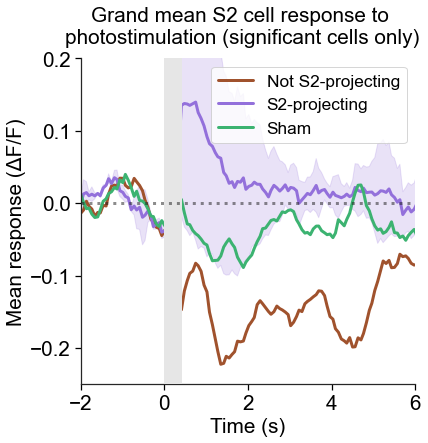

In [221]:
# GRAND AVERAGE FOR CELLS PASSING STATISTICAL TEST

test_type = 'fdr'
if test_type == 'fdr':
    stat_test = ['sta_sig_pr', 'sta_sig_ps', 'sta_sig_spont']
if test_type == 'nomulti':
    stat_test = ['sta_sig_nomulti_pr', 'sta_sig_nomulti_ps', 'sta_sig_nomulti_spont']
target_type = ['pr_target', 'ps_target', 'pr_target']
responses = ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(6,6))

n_numbers = []

n_numbers.append(f'n = {len(cell_df["session_id"].unique())} animals')

for test, label, target, response, color in zip(stat_test, plot_labels, target_type, responses, plot_colors):

    # filter dataframes using variables above
    s2_nontargets = cell_df[cell_df[test] & ~cell_df[target] & cell_df['s2_cell']].index
    
    # populate the plots with filtered data
    for col, cell_id_list in enumerate([s2_nontargets]):
        df_filter = cell_mean_timepoint_df['cell_id'].isin(cell_id_list)
        filtered_df = cell_mean_timepoint_df[df_filter].copy()
        filtered_df.loc[(filtered_df['timepoint'] > 0) & (filtered_df['timepoint'] <= photostim_duration), 
                ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
        rolling_mean = filtered_df.groupby('cell_id').rolling(5, min_periods=1).mean()[response]
    
        sns.lineplot(data=filtered_df, x='timepoint', y=rolling_mean.to_numpy(), 
                     estimator='mean', ci=95, ax=axes, label=label, legend=False, color=color, linewidth=plot_lw)

        display(fig)
        clear_output(wait = True)
        
        n_numbers.append(f'n = {len(cell_id_list.unique())} cells for {label} {target_text[col]}')

# construct patch to cover stim artifact period
stim_patch = patches.Rectangle((0,-100), patch_size, 999, zorder=3, color=patch_color)
axes.add_patch(stim_patch)
    
axes.set_xlabel('Time (s)')
axes.set_ylabel('')

axes.set_ylabel('Mean response (ΔF/F)');
axes.legend(plot_labels, loc='upper right');

axes.hlines(0, -2, 10, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);

if not projection:
    axes.set_ylim([-0.15, 0.15])
else:
    axes.set_ylim([-0.25, 0.2])

axes.set_xlim([-2, 6])

plt.subplots_adjust(wspace=0.4)
plt.suptitle('Grand mean S2 cell response to \nphotostimulation (significant cells only)', fontsize='xx-large', y=1)
    
save_path = fig_save_path + '_cell_grandaverage_s2_dff_trace_FDR'
ia.savePlot(save_path)

print('N_numbers:', *n_numbers, sep='\n')

N_numbers:
n = 3034 cells for Not S2-projecting non-targets
n = 3034 cells for S2-projecting non-targets
n = 3034 cells for Sham non-targets
n = 6 animals


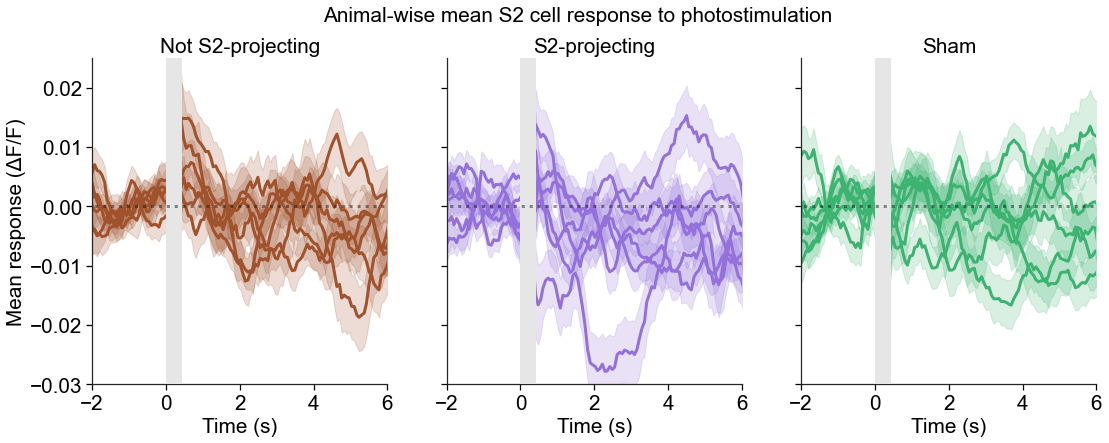

In [222]:
# TRACE AVERAGE PER ANIMAL OF ONLY S2 NON-TARGET

# list of column names to be used to filter the dataframe
target_type = ['pr_target', 'ps_target', 'pr_target']
responses = ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']

n_numbers = []

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, sharex=True, figsize=(18,6))

for target, response, color, label, ax in zip(target_type, responses, plot_colors, plot_labels, axes):

    # filter dataframes using variables above
    s2_nontargets = cell_df[~cell_df[target] & cell_df['s2_cell']].index
    
    df_filter = cell_mean_timepoint_df['cell_id'].isin(s2_nontargets)
    filtered_df = cell_mean_timepoint_df[df_filter]
    
    for session_id in filtered_df.session_id.unique():
        animal_df = filtered_df.loc[filtered_df.session_id == session_id].copy()
        animal_df.loc[(animal_df['timepoint'] > 0) & (animal_df['timepoint'] <= photostim_duration), 
                    ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
        rolling_mean = animal_df.groupby('cell_id').rolling(5, min_periods=1).mean()[response]
    
        sns.lineplot(data=animal_df, x='timepoint', y=rolling_mean.to_numpy(), 
                     estimator='mean', ci=95, ax=ax, color=color, linewidth=plot_lw)

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Mean response (ΔF/F)')
    ax.set_title(label)
    ax.hlines(0, -3, 11, linestyles='dotted', zorder=4, alpha=0.5, lw=3, color='k');
    ax.set_ylim([-0.03, 0.025])
    ax.set_xlim([-2,6])
    
    # construct patch to cover stim artifact period
    stim_patch = patches.Rectangle((0,-100), patch_size, 999, zorder=3, color=patch_color)
    ax.add_patch(stim_patch)
    
    target_text = ['targets', 'non targets']
    n_numbers.append(f'n = {len(s2_nontargets.unique())} cells for {label} non-targets')
    
    display(fig)
    clear_output(wait = True)
        
for ax in axes[1:3]:
    ax.set_ylabel('')

plt.suptitle('Animal-wise mean S2 cell response to photostimulation', fontsize='xx-large', y=1)
save_path = fig_save_path + '_cell_grandaverage_dff_trace_s2_animalwise'
ia.savePlot(save_path)
    
n_numbers.append(f'n = {len(cell_df["session_id"].unique())} animals')

print('N_numbers:', *n_numbers, sep='\n')

N_numbers:
n = 5005 cells for Not S2-projecting non-targets
n = 4969 cells for S2-projecting non-targets
n = 5005 cells for Sham non-targets
n = 6 animals


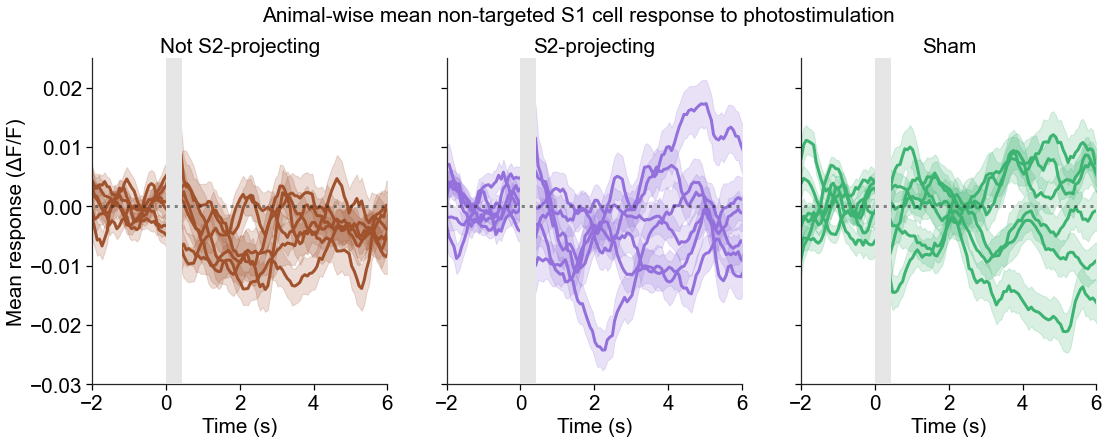

In [223]:
# TRACE AVERAGE PER ANIMAL OF ONLY S2 NON-TARGET

# list of column names to be used to filter the dataframe
target_type = ['pr_target', 'ps_target', 'pr_target']
responses = ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']

n_numbers = []

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, sharex=True, figsize=(18,6))

for target, response, color, label, ax in zip(target_type, responses, plot_colors, plot_labels, axes):

    # filter dataframes using variables above
    s1_nontargets = cell_df[~cell_df[target] & cell_df['s1_cell']].index
    
    df_filter = cell_mean_timepoint_df['cell_id'].isin(s1_nontargets)
    filtered_df = cell_mean_timepoint_df[df_filter]
    
    for session_id in filtered_df.session_id.unique():
        animal_df = filtered_df.loc[filtered_df.session_id == session_id].copy()
        animal_df.loc[(animal_df['timepoint'] > 0) & (animal_df['timepoint'] <= photostim_duration), 
                    ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
        rolling_mean = animal_df.groupby('cell_id').rolling(5, min_periods=1).mean()[response]
    
        sns.lineplot(data=animal_df, x='timepoint', y=rolling_mean.to_numpy(), 
                     estimator='mean', ci=95, ax=ax, color=color, linewidth=plot_lw)

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Mean response (ΔF/F)')
    ax.set_title(label)
    ax.hlines(0, -3, 11, linestyles='dotted', zorder=4, alpha=0.5, lw=3, color='k');
    ax.set_ylim([-0.03, 0.025])
    ax.set_xlim([-2,6])
    
    # construct patch to cover stim artifact period
    stim_patch = patches.Rectangle((0,-100), patch_size, 999, zorder=3, color=patch_color)
    ax.add_patch(stim_patch)
    
    target_text = ['targets', 'non targets']
    n_numbers.append(f'n = {len(s1_nontargets.unique())} cells for {label} non-targets')
    
    display(fig)
    clear_output(wait = True)
        
for ax in axes[1:3]:
    ax.set_ylabel('')

plt.suptitle('Animal-wise mean non-targeted S1 cell response to photostimulation', fontsize='xx-large', y=1)
save_path = fig_save_path + '_cell_grandaverage_dff_trace_s1nt_animalwise'
ia.savePlot(save_path)
    
n_numbers.append(f'n = {len(cell_df["session_id"].unique())} animals')

print('N_numbers:', *n_numbers, sep='\n')

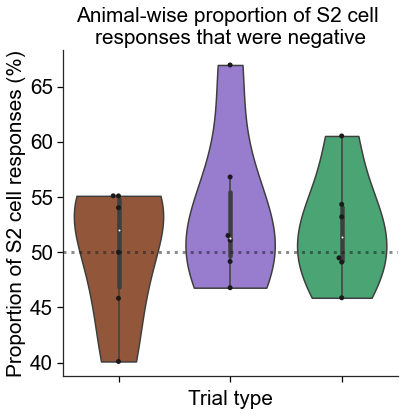

In [224]:
# list of column names to be used to filter the dataframe
target_type = ['pr_target', 'ps_target', 'pr_target']
sign_bool = ['pr_resp_sign', 'ps_resp_sign', 'spont_resp_sign']

s2_nontargets_neg_df = pd.DataFrame()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

for stim_id, label in enumerate(plot_labels):
        
    # define column names
    target = target_type[stim_id]
    sign = sign_bool[stim_id]
    
    s2_nontargets_neg = cell_df[~cell_df[target] & cell_df['s2_cell'] & 
                                ~cell_df[sign]].groupby('session_id').count()/cell_df[cell_df['s2_cell']].groupby('session_id').count()*100
    s2_nontargets_neg_df = pd.concat([s2_nontargets_neg_df, pd.DataFrame({label : s2_nontargets_neg['cell_num']})])

sns.swarmplot(data=s2_nontargets_neg_df, color='k',edgecolor='k')
sns.violinplot(data=s2_nontargets_neg_df, cut=0, scale='width', palette=sns.color_palette(plot_colors))
plt.hlines(50, -0.5, 2.5, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);
plt.xlabel('Trial type')
plt.ylabel('Proportion of S2 cell responses (%)')
plt.title('Animal-wise proportion of S2 cell \nresponses that were negative')

ax0_labels = [item.get_text() for item in ax.get_xticklabels()]
ax0_labels = ['','','']

ax.set_xticklabels(ax0_labels)

# save the figure
save_path = fig_save_path + '_proportion_nontarget_cell_negative_responses'
ia.savePlot(save_path)

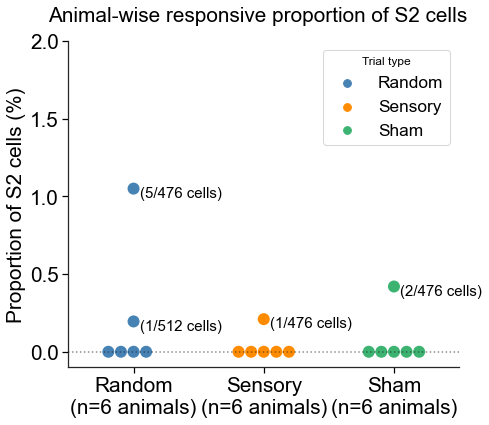

In [263]:
# list of column names to be used to filter the dataframe

# test_type = 'no multiple corrections'
test_type = 'FDR correction'
if test_type == 'FDR correction':
    stat_test = ['sta_sig_pr', 'sta_sig_ps', 'sta_sig_spont']
if test_type == 'no multiple corrections':
    stat_test = ['sta_sig_nomulti_pr', 'sta_sig_nomulti_ps', 'sta_sig_nomulti_spont']
target_type = ['pr_target', 'ps_target', 'pr_target']

s2_nontargets_df = pd.DataFrame()

# create and populate the plots using filtered data
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,6))

for stim_id, trial in enumerate(plot_labels):
        
    # define column names
    test = stat_test[stim_id]
    target = target_type[stim_id]
    
    # filter dataframes using variables above
    num_cells = cell_df[cell_df[test] & ~cell_df[target] & cell_df['s2_cell']].groupby('session_id').count()
    total_cells = cell_df[cell_df['s2_cell']].groupby('session_id').count()
    s2_nontargets = (num_cells/total_cells)*100
    s2_nontargets_df = pd.concat([s2_nontargets_df, 
                                  pd.DataFrame({'proportion' : s2_nontargets['cell_num'],
                                                'Trial type' : np.repeat(trial, len(s2_nontargets)),
                                                'num_cells' : num_cells['cell_num'],
                                                'total_cells' : total_cells['cell_num']
                                               },
                                               index=s2_nontargets.index)], axis=0)

s2_nontargets_df.fillna(0, inplace=True)

sns.swarmplot(data=s2_nontargets_df, x='Trial type', y='proportion', hue='Trial type', 
              ax=ax, palette=sns.color_palette(plot_colors), s=12)
# sns.swarmplot(data=s2_nontargets_df, x='trial_type', y='proportion', color='k', ax=ax, edgecolor='k')
# sns.violinplot(data=s2_nontargets_df, ax=ax, cut=0, scale='width')

ax.set_ylabel('Proportion of S2 cells (%)')
ax.set_xlabel('')
ax.hlines(0, -0.5, 2.5, linestyles='dotted', zorder=4, alpha=0.5, color='k');

buffer = 0.1

for row in s2_nontargets_df.iterrows():
    df_row = row[1]
    trial_type_dict = {plot_labels[0] : 0,
                       plot_labels[1] : 1,
                       plot_labels[2] : 2
                      }
    x = trial_type_dict[df_row['Trial type']] + 0.05
    y = df_row.proportion - (ax.get_ylim()[1]/20)
    s = f'({int(df_row["num_cells"])}/{df_row["total_cells"]} cells)'
    
    # verbose way of catching problems with text sitting too close together
    if df_row.proportion > 0:
        if df_row['Trial type'] == 'S2-projecting':
            y = df_row.proportion - buffer
            buffer = -0.05
            ax.text(x, y, s, fontsize=15)
            continue
        ax.text(x, y, s, fontsize=15)

ax1_labels = [item.get_text() + '\n(n=6 animals)' for item in ax.get_xticklabels()]
if ax1_labels[0] == 'Not S2-projecting\n(n=6 animals)': ax1_labels[0] = 'Not S2-proj.\n(n=6 animals)'

ax.set_xticklabels(ax1_labels)
# ax.legend().set_visible(False)
ax.set_ylim(-0.1,2)

plt.suptitle('Animal-wise responsive proportion of S2 cells', y=0.96, fontsize='xx-large');

# save the figure
save_path = fig_save_path + '_proportion_responsive_s2_cells_' + test_type
ia.savePlot(save_path)

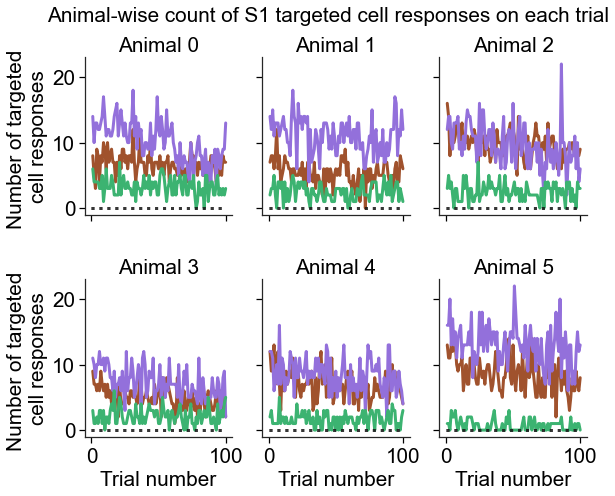

In [226]:
trials = ['pr', 'ps', 'spont']
targets = ['pr', 'ps', 'pr']

session_ids = cell_trial_df['session_id'].unique()   
ncols = np.round(len(session_ids)/2).astype('int')

if not projection:
    fig, axes = plt.subplots(nrows=2, ncols=ncols, sharey=True, sharex=True, figsize=(3*ncols,7))
else:
    fig, axes = plt.subplots(nrows=2, ncols=ncols, sharey=True, sharex=True, figsize=(3*ncols,7))

for color, trial, target, label in zip(plot_colors, trials, targets, plot_labels):
    
    target_cell_ids = cell_df.query(target + '_target & ' + trial + '_resp_sign').index

    target_filter = cell_trial_df['cell_id'].isin(target_cell_ids)
    
    filtered_df = cell_trial_df[target_filter] \
                   .groupby(['session_id', 'trial_num'])['trial_sig_dff_' + trial] \
                   .sum() \
                   .reset_index(drop=False) \
    
    for ax_i, ax in enumerate(axes.flatten()):
        
        if ax_i >= len(session_ids): ax.axis('off')
            
        try:
            animal_df = filtered_df[filtered_df['session_id']==session_ids[ax_i]]
        except:
            break
        
        sns.lineplot(x='trial_num', y='trial_sig_dff_'+trial, data=animal_df, ci=None, ax=ax, 
                     label=label, legend=False, color=color, linewidth=plot_lw)
#         ax.set_title(session_ids[ax_i])
        ax.set_title('Animal ' + str(ax_i))
        
        ax.set_ylabel('Number of targeted \ncell responses')
            
        ax.hlines(0, 0, 100, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);
    
    for ax in axes[1]:
        ax.set_xlabel('Trial number')
                    
plt.suptitle('Animal-wise count of S1 targeted cell responses on each trial', y=0.98, fontsize='xx-large');
plt.subplots_adjust(hspace=0.4)

# save the figure
save_path = fig_save_path + '_animalwise_trialwise_number_targets_responding'
ia.savePlot(save_path)

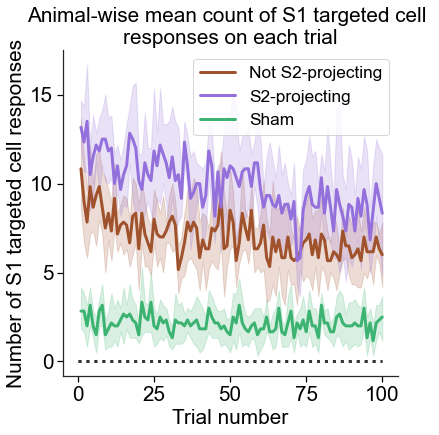

In [227]:
trials = ['pr', 'ps', 'spont']
targets = ['pr', 'ps', 'pr']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

for color, trial, target, label in zip(plot_colors, trials, targets, plot_labels):
    
    target_cell_ids = cell_df.query(target + '_target & ' + trial + '_resp_sign').index

    target_filter = cell_trial_df['cell_id'].isin(target_cell_ids)
    
    filtered_df = cell_trial_df[target_filter] \
                   .groupby(['session_id', 'trial_num'])['trial_sig_dff_' + trial] \
                   .sum() \
                   .reset_index(drop=False) \

    sns.lineplot(x='trial_num', y='trial_sig_dff_'+trial, data=filtered_df, ci=95, estimator='mean', ax=ax, 
                 label=label, legend=False, color=color, linewidth=3)

    ax.legend(plot_labels)
    ax.set_xlabel('Trial number')
    ax.set_ylabel('Number of S1 targeted cell responses')

    ax.hlines(0, 0, 100, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);
                    
    ax.set_title('Animal-wise mean count of S1 targeted cell \nresponses on each trial', y=1, fontsize='xx-large');

# save the figure
save_path = fig_save_path + '_trialwise_average_target_cells_responding'
ia.savePlot(save_path)

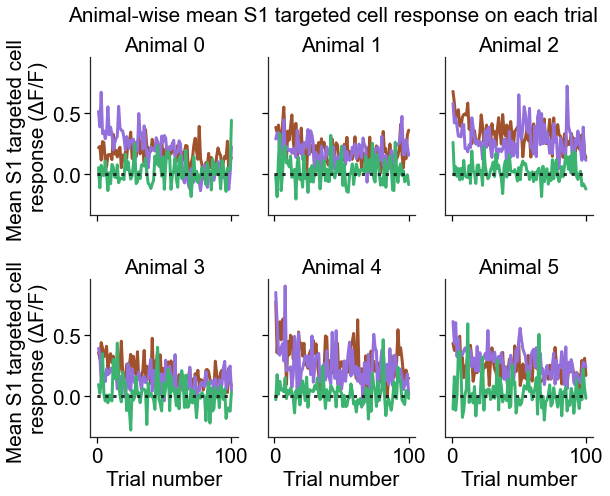

In [228]:
trials = ['pr', 'ps', 'spont']
targets = ['pr', 'ps', 'pr']

session_ids = cell_trial_df['session_id'].unique()   
ncols = np.round(len(session_ids)/2).astype('int')

if not projection:
    fig, axes = plt.subplots(nrows=2, ncols=ncols, sharey=True, sharex=True, figsize=(3*ncols,7))
else:
    fig, axes = plt.subplots(nrows=2, ncols=ncols, sharey=True, sharex=True, figsize=(3*ncols,7))

for color, trial, target, label in zip(plot_colors, trials, targets, plot_labels):
    
    target_cell_ids = cell_df.query(target + '_target & ' + trial + '_resp_sign').index

    target_filter = cell_trial_df['cell_id'].isin(target_cell_ids)
    
    filtered_df = cell_trial_df[target_filter] \
                   .groupby(['session_id', 'trial_num'])[trial + '_amp_resp'] \
                   .mean() \
                   .reset_index(drop=False) \
    
    for ax_i, ax in enumerate(axes.flatten()):
        
        if ax_i >= len(session_ids): ax.axis('off')
            
        try:
            animal_df = filtered_df[filtered_df['session_id']==session_ids[ax_i]]
        except:
            break
        
        sns.lineplot(x='trial_num', y=trial + '_amp_resp', data=animal_df, ci=None, ax=ax, 
                     label=label, legend=False, color=color, linewidth=plot_lw)

        ax.set_title('Animal ' + str(ax_i))
             
        ax.set_ylabel('Mean S1 targeted cell \nresponse (ΔF/F)')
   
        ax.hlines(0, 0, 100, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);
    
    for ax in axes[1]:
        ax.set_xlabel('Trial number')
                    
plt.suptitle('Animal-wise mean S1 targeted cell response on each trial', y=0.98, fontsize='xx-large');
plt.subplots_adjust(hspace=0.4)
# save the figure
save_path = fig_save_path + '_animalwise_trialwise_mean_target_response'
ia.savePlot(save_path)

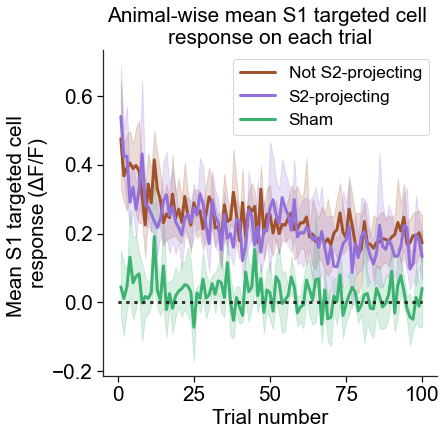

In [229]:
trials = ['pr', 'ps', 'spont']
targets = ['pr', 'ps', 'pr']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

for color, trial, target, label in zip(plot_colors, trials, targets, plot_labels):
    
    target_cell_ids = cell_df.query(target + '_target & ' + trial + '_resp_sign').index

    target_filter = cell_trial_df['cell_id'].isin(target_cell_ids)
    
    filtered_df = cell_trial_df[target_filter] \
                   .groupby(['session_id', 'trial_num'])[trial + '_amp_resp'] \
                   .mean() \
                   .reset_index(drop=False) \

    sns.lineplot(x='trial_num', y=trial + '_amp_resp', data=filtered_df, ci=95, estimator='mean', 
                 ax=ax, label=label, legend=False, color=color, linewidth=3)

    ax.legend(plot_labels)
    ax.set_xlabel('Trial number')
    ax.set_ylabel('Mean S1 targeted cell \nresponse (ΔF/F)')

    ax.hlines(0, 0, 100, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);
                    
    ax.set_title('Animal-wise mean S1 targeted cell \nresponse on each trial', y=1, fontsize='xx-large');

# save the figure
save_path = fig_save_path + '_trialwise_average_target_cell_responses'
ia.savePlot(save_path)

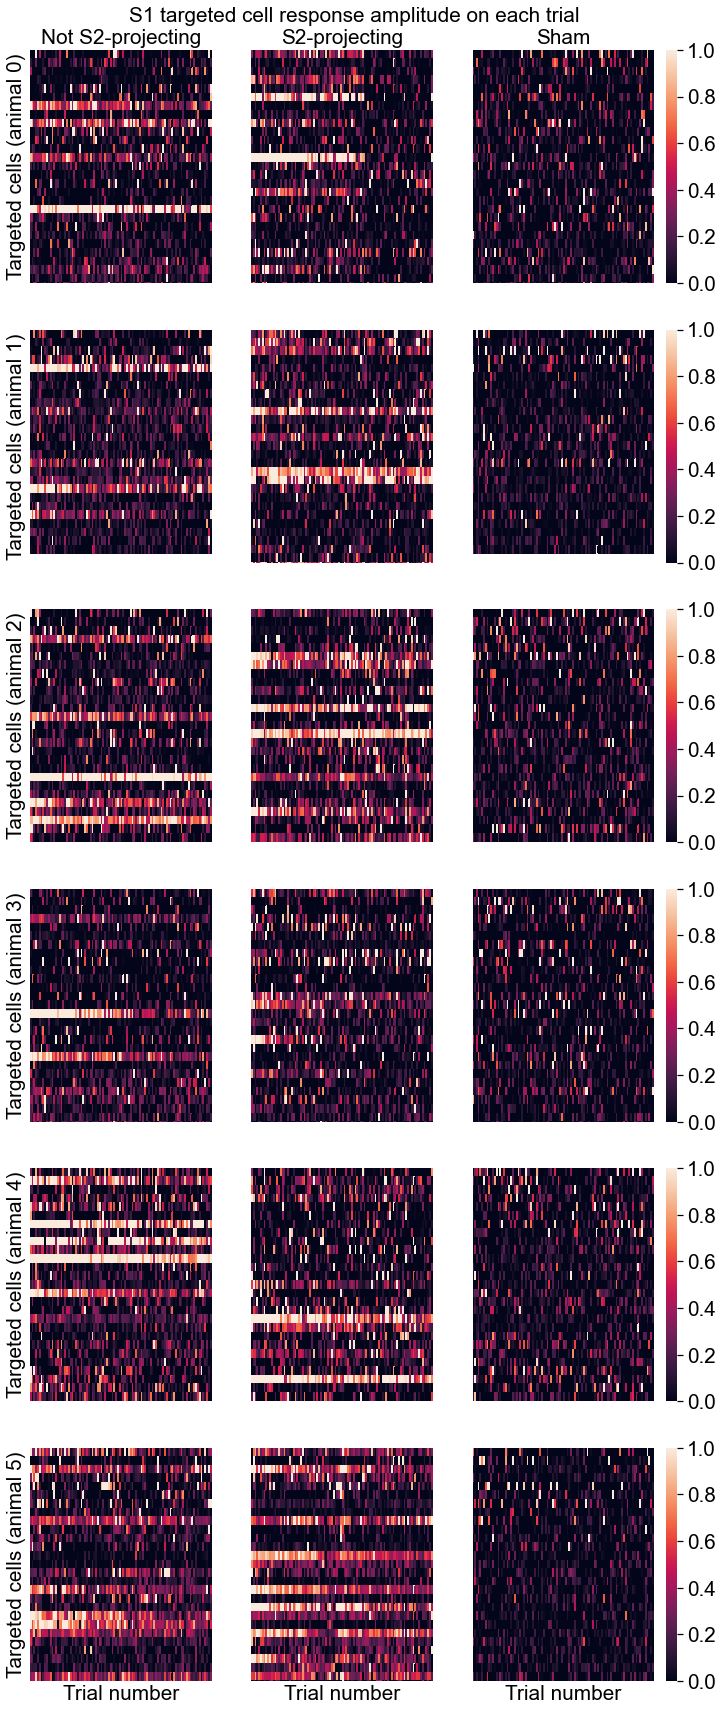

In [230]:
# plot 2d heatmap of target cells (y-axis) vs. activity using trial + _amp_resp from cell_trial_df (x-axis)

trials = ['pr', 'ps', 'spont']
targets = ['pr', 'ps', 'pr']

session_ids = cell_trial_df['session_id'].unique()   

fig, axes = plt.subplots(nrows=len(session_ids), ncols=3, 
                         sharey=True, sharex=True, figsize=(12,5*len(session_ids)), 
                         gridspec_kw={'width_ratios':(8, 8, 10)})

for row_i, session_id in enumerate(session_ids):
        
    session_group = cell_df[cell_df['session_id']==session_id]
    
    for col_i, (trial, target, label, ax) in enumerate(zip(trials, targets, plot_labels, axes[row_i])):
    
#         target_cell_ids = session_group.query('~' + target + '_target & s2_cell').index
        target_cell_ids = session_group.query(target + '_target').index
        target_filter = cell_trial_df['cell_id'].isin(target_cell_ids)
        filtered_df = cell_trial_df[target_filter]

        crop_df = filtered_df.loc[:,['cell_num', 'trial_num', trial + '_amp_resp']]
        pivot_df = crop_df.pivot('cell_num', 'trial_num', trial + '_amp_resp')
        
        if col_i==2:
            sns.heatmap(pivot_df, vmin=0, vmax=1, ax=ax, xticklabels=False, yticklabels=False)
        else:
            sns.heatmap(pivot_df, vmin=0, vmax=1, cbar=False, ax=ax, xticklabels=False, yticklabels=False)
            
        if row_i==0: ax.set_title(label)
        
        if row_i==(len(session_ids)-1): ax.set_xlabel('Trial number') 
        else: ax.set_xlabel('')
        
        if col_i == 0: ax.set_ylabel(f'Targeted cells (animal {row_i})')
        else: ax.set_ylabel('')
        
        plt.suptitle('S1 targeted cell response amplitude on each trial', fontsize='xx-large', y=0.9);
        
save_path = fig_save_path + '_animalwise_trialwise_target_response_heatmap'
ia.savePlot(save_path)

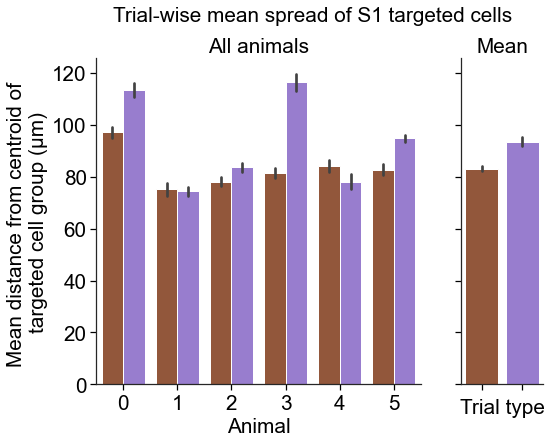

In [231]:
trials = ['pr', 'ps']

df = trial_df[trial_df.stim_type.isin(trials)]
unique_animals = len(cell_df.session_id.unique())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6), sharey=True, gridspec_kw={'width_ratios':(4,1)})

sns.barplot(data=df, y='trial_target_euclid_dist', x='session_id', hue='stim_type', 
            ax=axes[0], palette=sns.color_palette(plot_colors))
sns.barplot(data=df, y='trial_target_euclid_dist', x='stim_type', 
            ax=axes[1], palette=sns.color_palette(plot_colors))

axes[0].set_ylabel('Mean distance from centroid of \ntargeted cell group (μm)')
axes[1].set_ylabel('')

axes[0].set_xlabel('Animal')
axes[1].set_xlabel('Trial type')
    
axes[0].set_title('All animals')
axes[1].set_title('Mean');

axes[0].legend().set_visible(False)

ax0_labels = [item.get_text() for item in axes[0].get_xticklabels()]
ax0_labels = list(range(0,unique_animals))

axes[0].set_xticklabels(ax0_labels)

ax1_labels = [item.get_text() for item in axes[1].get_xticklabels()]
ax1_labels = ['','']

axes[1].set_xticklabels(ax1_labels)

plt.suptitle('Trial-wise mean spread of S1 targeted cells', fontsize='xx-large', y=1)

# save the figure
save_path = fig_save_path + '_target_cell_spread'
ia.savePlot(save_path)

Loading pickle: /home/rlees/mnt/qnap/pkl_files/projection_2sec_test/2021-02-24_RL132.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/projection_2sec_test/2021-02-18_RL127.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/projection_2sec_test/2021-02-23_RL129.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/projection_2sec_test/2021-03-02_RL130.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/projection_2sec_test/2021-02-25_RL131.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/projection_2sec_test/2021-02-22_RL128.pkl
[82.31429938295362, 18.761265599319255, 62.561847380058694, 84.48319435488119, 149.66111553842305, 97.27195598686875]


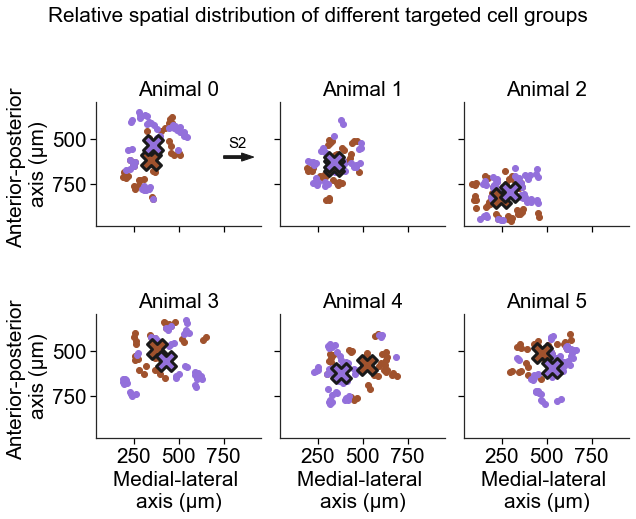

In [232]:
# plot difference between target cloud centroids

stim_types = ['pr', 'ps']
pkl_files = ia.listdirFullpath(os.path.join(pkl_folder, session_type), string='.pkl')
pkl_files = [file for file in pkl_files if not any(s in file for s in remove_list)]
dist = []

session_ids = cell_trial_df['session_id'].unique()   
ncols = np.round(len(session_ids)/2).astype('int')

if not projection:
    fig, axes = plt.subplots(nrows=2, ncols=ncols, sharex=True, sharey=True, figsize=(3*ncols, 9))
else:
    fig, axes = plt.subplots(nrows=2, ncols=ncols, sharey=True, sharex=True, figsize=(3*ncols, 9))

cloud_axes = axes.flatten()

for i, pkl in enumerate(pkl_files):
    
    ses_obj = ia.loadPickle(pkl)
    
    exp_list = ia.makeExpList(ses_obj, stim_types)
    
    coords = []
    
    for exp_obj, color in zip(exp_list, plot_colors):
        
        cell_meds = np.array(exp_obj.cell_med[0])*exp_obj.pix_sz_x
        target_cell_meds = cell_meds[exp_obj.targeted_cells]
        
        x = target_cell_meds[:,1].mean()
        y = target_cell_meds[:,0].mean()
        
        cloud_axes[i].scatter(target_cell_meds[:,1], target_cell_meds[:,0], zorder=-1, color=color)
        cloud_axes[i].scatter(x, y, marker='X', linewidth=plot_lw, edgecolors='k', s=400, color=color)
        
        cloud_axes[i].set_title('Animal ' + str(i))
        
        coords.append([x,y])
    
    dist_x = coords[0][0] - coords[1][0]
    dist_y = coords[0][1] - coords[1][1]
    
    dist.append(np.sqrt(dist_x**2 + dist_y**2))
    
for row, row_ax in enumerate(axes):
    for col, col_ax in enumerate(row_ax):
        if col == 0: col_ax.set_ylabel('Anterior-posterior \naxis (μm)')
        if row == 1: col_ax.set_xlabel('Medial-lateral \naxis (μm)')
        col_ax.set_aspect('equal')
        
        if (row==0) and (col==0): 
            col_ax.arrow(750, 600, 100, 0, width=15, color='k')
            col_ax.text(775, 550, 'S2', fontsize=15)

axes[0,0].invert_yaxis()

fig.tight_layout(h_pad=-8)

plt.suptitle('Relative spatial distribution of different targeted cell groups', fontsize='xx-large', y=0.92)

print(dist)

save_path = fig_save_path + '_target_group_centroid_positions'
ia.savePlot(save_path)

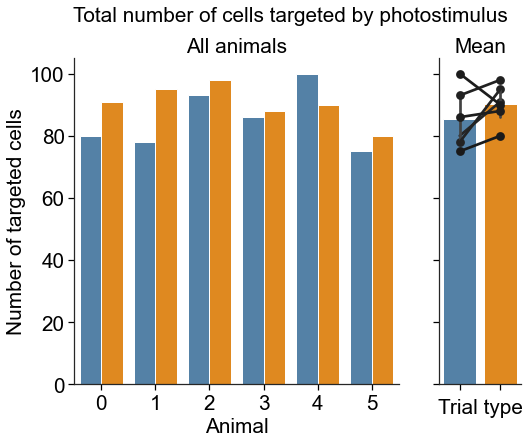

In [26]:
df = pd.DataFrame()

unique_animals = len(cell_df.session_id.unique())

targets = ['pr_target', 'ps_target']

for target in targets:
    target_df = cell_df.query(target)
    
    num_targets = target_df.groupby('session_id')[target].count()

    session_labels = [session_id[-5:] for session_id in target_df['session_id'].unique()]

    temp_df = pd.DataFrame({'target_type' : np.repeat(target, len(num_targets)),
                            'num_targets' : num_targets,
                            'session_id' : session_labels
                           })
    
    df = pd.concat([df, temp_df])
    
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6), sharey=True, gridspec_kw={'width_ratios':(4, 1)})

sns.barplot(data=df, x='session_id', y='num_targets', hue='target_type', 
            ax=axes[0], palette=sns.color_palette(plot_colors));
sns.barplot(data=df, y='num_targets', x='target_type', 
            ax=axes[1], palette=sns.color_palette(plot_colors));
# sns.swarmplot(x='target_type', y='num_targets', size=3, dodge=True, data=df, 
#               ax=axes[1], color='k')
sns.pointplot(data=df, x="target_type", y="num_targets", hue='session_id', color='k', dodge=False)
axes[1].legend().set_visible(False)

for ax in axes:
    ax.set_ylabel('Number of targeted cells');
    
axes[0].set_xlabel('Animal')
axes[1].set_xlabel('Trial type')

axes[0].set_title('All animals')
axes[1].set_title('Mean')

axes[0].legend().set_visible(False)
axes[1].set_ylabel('')

ax0_labels = [item.get_text() for item in axes[0].get_xticklabels()]
ax0_labels = list(range(0,unique_animals))

axes[0].set_xticklabels(ax0_labels)

ax1_labels = [item.get_text() for item in axes[1].get_xticklabels()]
ax1_labels = ['','']

axes[1].set_xticklabels(ax1_labels)

plt.suptitle('Total number of cells targeted by photostimulus', fontsize='xx-large', y=1);

# save the figure
save_path = fig_save_path + '_target_cell_group_size'
ia.savePlot(save_path)

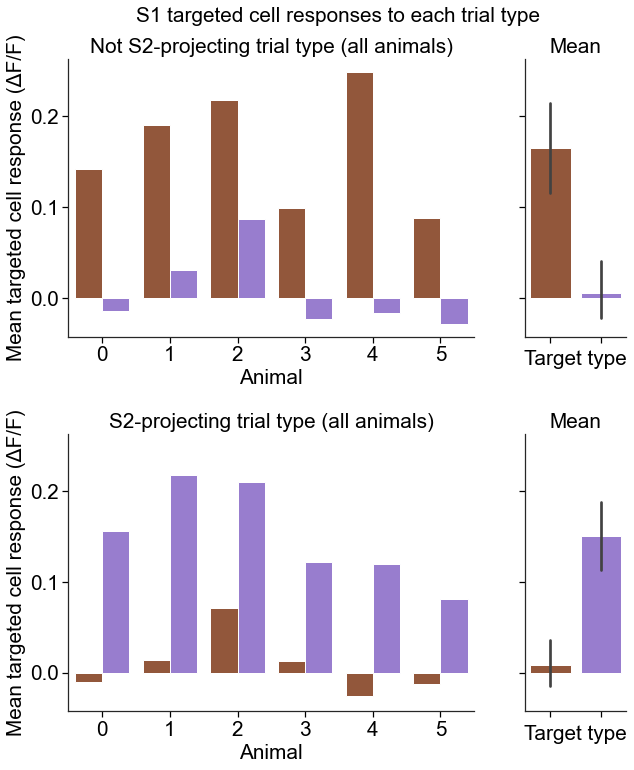

In [234]:
targets = ['pr_target', 'ps_target']
trials = ['pr', 'ps']

unique_animals = len(cell_df.session_id.unique())

fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10,12), gridspec_kw={'width_ratios':(4, 1)})

for i, (trial, label, ax) in enumerate(zip(trials, plot_labels, axes)):

    df = pd.DataFrame()

    for target in targets:

        target_df = cell_df.query(target)

        mean_resp_target = target_df.groupby('session_id').mean()[trial + '_sta_amp_resp']
        session_labels = mean_resp_target.groupby('session_id').mean().index.to_numpy()

    #     ctb_positive_filter = cell_mean_timepoint_df.cell_id.isin(ctb_positive_targets)
    #     ctb_positive_df = cell_mean_timepoint_df[ctb_positive_filter]

    #     ctb_negative_filter = cell_mean_timepoint_df.cell_id.isin(ctb_negative_targets)
    #     ctb_negative_df = cell_mean_timepoint_df[ctb_negative_filter]

        temp_df = pd.DataFrame({'mean_resp' : mean_resp_target,
                                'Target type' : np.repeat(target, len(mean_resp_target)),
                                'session_id' : [session_label[-5:] for session_label in session_labels]
                               })

        df = pd.concat([df, temp_df])

    sns.barplot(data=df, x='session_id', y='mean_resp', hue='Target type', 
                palette=sns.color_palette(plot_colors), ax=ax[0])
    sns.barplot(data=df, y='mean_resp', x='Target type', 
                palette=sns.color_palette(plot_colors), ax=ax[1])

    ax[0].set_title(label + ' trial type (all animals)')
    ax[0].set_ylabel('Mean targeted cell response (ΔF/F)')
    ax[0].set_xlabel('Animal')

    ax[1].set_ylabel('')
    ax[1].set_title('Mean')

    ax0_labels = [item.get_text() for item in ax[0].get_xticklabels()]
    ax0_labels = list(range(0,unique_animals))

    ax[0].set_xticklabels(ax0_labels)

    ax1_labels = [item.get_text() for item in ax[1].get_xticklabels()]
    ax1_labels = ['','']

    ax[1].set_xticklabels(ax1_labels)

    ax[0].legend().set_visible(False)

plt.suptitle('S1 targeted cell responses to each trial type', fontsize='xx-large', y=0.94);
plt.subplots_adjust(hspace=0.35)

# save the figure
save_path = fig_save_path + '_target_cell_group_response_by_trialtype'
ia.savePlot(save_path)

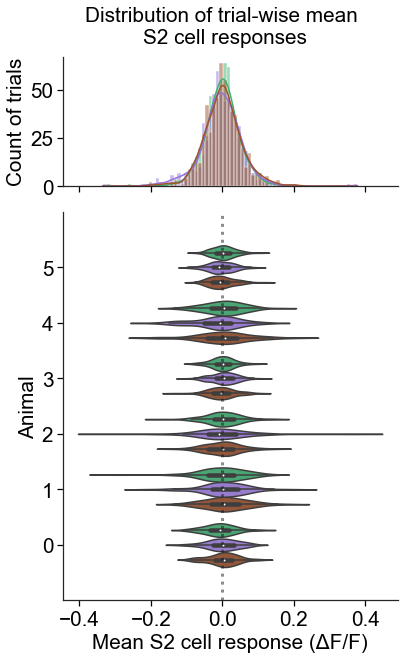

In [235]:
target_types = ['pr', 'ps', 'pr']
trial_types = ['pr', 'ps', 'spont']

unique_animals = len(cell_df.session_id.unique())

df = pd.DataFrame()

for target, trial in zip(target_types, trial_types):

    s2_nontarget_cell_ids = cell_df.query('~' + target + '_target & s2_cell').index
    
    cell_id_list = [s2_nontarget_cell_ids]
    
    for i, cell_ids in enumerate(cell_id_list):
        
        cell_filter = cell_trial_df['cell_id'].isin(cell_ids)
        filtered_df = cell_trial_df[cell_filter]
        
        mean_df = filtered_df.groupby(['session_id', 'trial_num']).mean().reset_index(drop=False)
        temp_df = pd.DataFrame({'session_id' : mean_df['session_id'],
                                'trial_num' : mean_df['trial_num'],
                                'trial_type' : np.repeat(trial, len(mean_df)),
                                'mean_activity' : mean_df[trial + '_amp_resp']
                               })
        df = pd.concat([df, temp_df])
        
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6,10), gridspec_kw={'height_ratios':(1, 3)})

# top plot
s2_cell_ids = cell_df.query('s2_cell').index
s2_df = cell_trial_df[cell_trial_df['cell_id'].isin(s2_cell_ids)]
long_df = s2_df.reset_index(drop=False).melt(id_vars=['trial_num', 'session_id'], 
                                             value_vars=['pr_amp_resp', 'ps_amp_resp', 'spont_amp_resp'])
summed_df = long_df.groupby(['trial_num', 'session_id', 'variable']).mean()

summed_df[summed_df['value']==0] = np.nan

sns.histplot(kde=True, data=summed_df.reset_index(), x='value',
             hue='variable', palette=sns.color_palette(plot_colors), ax=axes[0], legend=False);

axes[0].set_xlabel('')
axes[0].set_ylabel('Count of trials')

#bottom plot
session_ids = cell_df['session_id'].unique()
animal_ids = [session_id.split('_')[-1] for session_id in session_ids]

# sns.swarmplot(x='session_id', y='mean_activity', hue='trial_type', size=3, dodge=True, data=df, 
#               ax=axes, color='k')
sns.violinplot(y='session_id', x='mean_activity', hue='trial_type', size=3, dodge=True, data=df, 
               ax=axes[1], palette=sns.color_palette(plot_colors))

axes[1].set_yticklabels(animal_ids)
axes[1].set_xlabel('Mean S2 cell response (ΔF/F)')
axes[1].legend().set_visible(False)

ax0_labels = [item.get_text() for item in axes[1].get_yticklabels()]
ax0_labels = list(range(0,unique_animals))

axes[1].set_yticklabels(ax0_labels)
axes[1].set_ylabel('Animal')

axes[1].vlines(0, -1, 17, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);
axes[1].set_ylim([-1, unique_animals]);

plt.subplots_adjust(hspace=0.1)

plt.suptitle('Distribution of trial-wise mean \nS2 cell responses', fontsize='xx-large', y=0.95)

# save the figure
save_path = fig_save_path + '_s2_cell_mean_activity_trialwise_animalwise'
ia.savePlot(save_path)

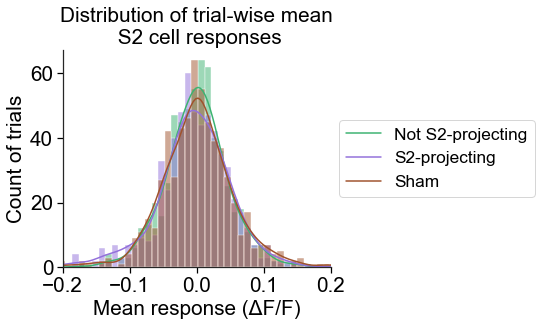

In [236]:
# PLOT DISTRIBUTION OF SUMMED S2 TRIAL RESPONSES

s2_cell_ids = cell_df.query('s2_cell').index
s2_df = cell_trial_df[cell_trial_df['cell_id'].isin(s2_cell_ids)]
long_df = s2_df.reset_index(drop=False).melt(id_vars=['trial_num', 'session_id'], 
                                             value_vars=['pr_amp_resp', 'ps_amp_resp', 'spont_amp_resp'])
summed_df = long_df.groupby(['trial_num', 'session_id', 'variable']).mean()

summed_df[summed_df['value']==0] = np.nan

sns.histplot(kde=True, data=summed_df.reset_index(), x='value',
             hue='variable', palette=sns.color_palette(plot_colors));

axes = plt.gca()
box = axes.get_position()
axes.set_position([box.x0, box.y0, box.width * 0.8, box.height])
axes.legend(plot_labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.axis([-0.2, 0.2, None, None])
plt.xlabel('Mean response (ΔF/F)')
plt.ylabel('Count of trials')
plt.title('Distribution of trial-wise mean\n S2 cell responses');

# save the figure
save_path = fig_save_path + '_distribution_s2_cell_responses'
ia.savePlot(save_path)

/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


trial: Not S2-projecting slope 0.15240383090312234 r_value 0.15240383068878482 p_value 0.00017878888864072444


/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


trial: S2-projecting slope 0.2659194586891544 r_value 0.2659194656951214 p_value 3.6008241058547494e-11


/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


trial: Sham slope 0.23059680061074878 r_value 0.23059679761854973 p_value 1.1044973281360097e-08


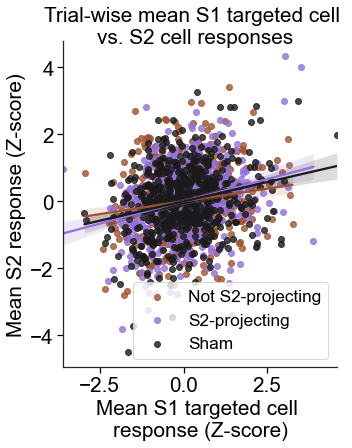

In [237]:
# Z SCORING

responses = ['pr_amp_resp', 'ps_amp_resp', 'spont_amp_resp']
targets = ['pr_target', 'ps_target', 'pr_target']

colors = plot_colors[:2]
colors.append('k')

# create and populate the plots using filtered data
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(6,6))

for response, target, label, color in zip(responses, targets, plot_labels, colors):
    
    s2_cell_ids = cell_df.query('s2_cell & ~' + target).index
    target_cell_ids = cell_df.query(target).index

    target_filter = cell_trial_df['cell_id'].isin(target_cell_ids)
    target_df = cell_trial_df[target_filter].dropna(axis=0, subset=[response])
    target_amp_resp = target_df.groupby(['trial_num','session_id']).mean()
    target_amp_resp = target_amp_resp.groupby('session_id').transform(lambda x : stats.zscore(x, ddof=1))[response]

    s2_filter = cell_trial_df['cell_id'].isin(s2_cell_ids)
    s2_df = cell_trial_df[s2_filter].dropna(axis=0, subset=[response])
    s2_amp_resp = s2_df.groupby(['trial_num','session_id']).mean()
    s2_amp_resp = s2_amp_resp.groupby('session_id').transform(lambda x : stats.zscore(x, ddof=1))[response]

    df = pd.DataFrame({'target_amp_resp' : target_amp_resp,
                       's2_amp_resp'     : s2_amp_resp})

    df = df.reset_index(drop=False)
    
    sns.regplot(x=df['target_amp_resp'], y=df['s2_amp_resp'], 
            data=df, ax=axes, label=label, color=color)

    axes.set_ylabel('Mean S2 response (Z-score)')
    axes.legend()
    axes.set_xlabel('Mean S1 targeted cell \nresponse (Z-score)')

    axes.set_aspect('equal')
    
    slope, _, r_value, p_value, _ = stats.linregress(x=df['target_amp_resp'], 
                                                     y=df['s2_amp_resp'])
    print('trial:', label,
          'slope', slope,
          'r_value', r_value,
          'p_value', p_value
         )
            
plt.suptitle('Trial-wise mean S1 targeted cell \nvs. S2 cell responses', y=0.96, 
         fontsize='xx-large');

# save the figure
save_path = fig_save_path + '_target_s2_activity_correlation_trialwise_zscore'
ia.savePlot(save_path)

N_numbers:
n = 3034 non-target s2 cells for pr
n = 3034 non-target s2 cells for ps


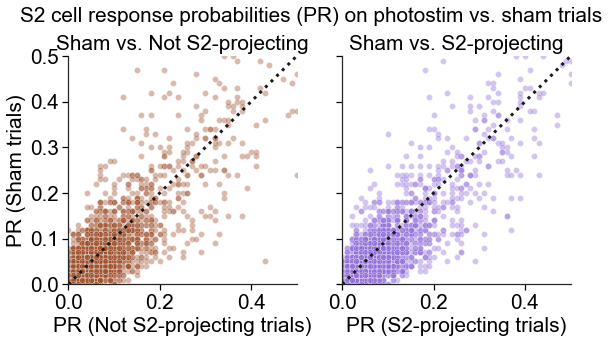

In [270]:
trials = ['pr', 'ps']

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(9,6))

n_numbers = []

for i, (trial, ax, label, color) in enumerate(zip(trials, axes, plot_labels, plot_colors)):
    df = cell_df.query('~' + trial + '_target & s2_cell')
    
#     sns.histplot(x='prob_response_'+trial, y='prob_response_spont',
#                  data=df, ax=ax, binwidth=(0.01,0.01), cbar=True, 
#                  cbar_kws={'shrink':.75, 'label': 'Number of cells', 'orientation':'horizontal', 'extend':'max'}, 
#                  vmin=0, vmax=100, color='k')
    sns.scatterplot(x='prob_response_'+trial, y='prob_response_spont', data=df, ax=ax, 
                    alpha=0.4, color=color)
    ax.set_aspect('equal')
    ax.axis([0,0.5,0,0.5]);
    
    ax.set_xlabel(f'PR ({label} trials)')
    ax.set_ylabel('PR (Sham trials)')
    ax.set_title(f'Sham vs. {label}')
    
    ax.plot([0,1],[0,1], 'k', linestyle='dotted', lw=3)
    
    n_numbers.append(f'n = {len(df.index.unique())} non-target s2 cells for {trial}')

plt.suptitle('S2 cell response probabilities (PR) on photostim vs. sham trials', 
             y=0.88, fontsize='xx-large');

print('N_numbers:', *n_numbers, sep='\n')

# save the figure
save_path = fig_save_path + '_s2_cell_response_probability'
ia.savePlot(save_path)

Not S2-projecting, Sham MannwhitneyuResult(statistic=4592271.0, pvalue=0.43996718281630526)
S2-projecting, Sham MannwhitneyuResult(statistic=4499507.0, pvalue=0.06544458500960915)
Not S2-projecting, S2-projecting MannwhitneyuResult(statistic=4510050.0, pvalue=0.08753586684567899)


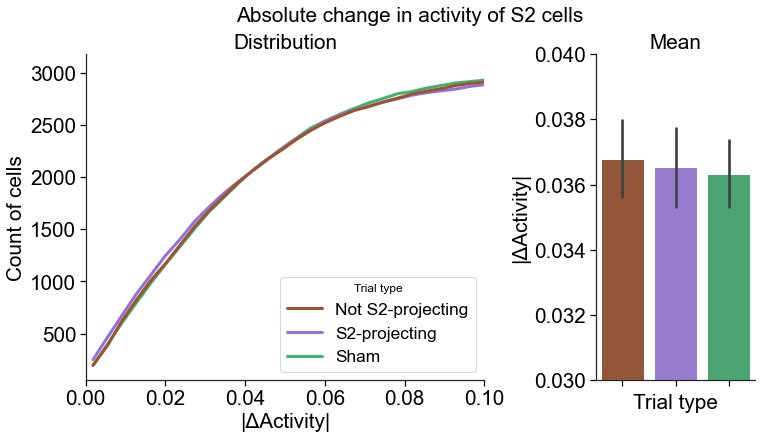

In [239]:
trials = ['pr', 'ps', 'spont']
targets = ['pr', 'ps', 'pr']

df = pd.DataFrame()

for i, (trial, target, label) in enumerate(zip(trials, targets, plot_labels)):
    
    non_target_df = cell_df.query('~' + target + '_target & s2_cell')
    influence = non_target_df[trial + '_avg_norm_influence']
    
    temp_df = pd.DataFrame({'Trial type' : np.repeat(label, len(influence)),
                            'influence' : np.absolute(influence)
                           })
    
    df = pd.concat([df, temp_df])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), gridspec_kw={'width_ratios':(5, 2)})

sns.barplot(x='Trial type', y='influence', data=df, ci=95, ax=ax[1], palette=sns.color_palette(plot_colors));
ax[1].set_ylabel('|ΔActivity|')
ax[1].set_ylim([0.03, 0.04])
ax[1].set_title('Mean')

# sns.kdeplot(cumulative=True, hue='Trial type', x='influence', data=df, cut=0, ax=ax[1])
sns.histplot(x='influence', element='poly', hue='Trial type', cumulative=True, fill=False,
             linewidth=plot_lw, data=df, ax=ax[0], palette=sns.color_palette(plot_colors))
ax[0].set_xlabel('|ΔActivity|')
ax[0].set_ylabel('Count of cells')
ax[0].set_xlim(0, 0.1)
ax[0].set_title('Distribution')

ax1_labels = [item.get_text() for item in ax[1].get_xticklabels()]
ax1_labels = ['','', '']

ax[1].set_xticklabels(ax1_labels)

plt.suptitle('Absolute change in activity of S2 cells', y=0.99, fontsize='xx-large');
plt.subplots_adjust(wspace=0.4)

group1 = df[df['Trial type']==plot_labels[0]]['influence'].to_numpy()
group2 = df[df['Trial type']==plot_labels[1]]['influence'].to_numpy()
group3 = df[df['Trial type']==plot_labels[2]]['influence'].to_numpy()

print(f'{plot_labels[0]}, {plot_labels[2]}', stats.mannwhitneyu(group1, group3))
print(f'{plot_labels[1]}, {plot_labels[2]}', stats.mannwhitneyu(group2, group3))
print(f'{plot_labels[0]}, {plot_labels[1]}', stats.mannwhitneyu(group1, group2))

# save the figure
save_path = fig_save_path + '_deltaactivity_magnitude_histogram_barplot'
ia.savePlot(save_path)

Not S2-projecting, Sham MannwhitneyuResult(statistic=4446692.0, pvalue=0.01116629019655768)
S2-projecting, Sham MannwhitneyuResult(statistic=4569371.0, pvalue=0.3132441165272602)
Not S2-projecting, S2-projecting MannwhitneyuResult(statistic=4413157.0, pvalue=0.0027503126307192732)


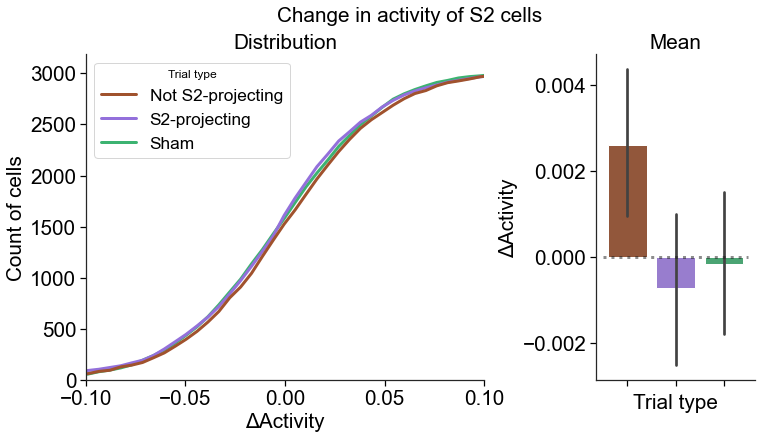

In [240]:
trials = ['pr', 'ps', 'spont']
targets = ['pr', 'ps', 'pr']

df = pd.DataFrame()

for i, (trial, target, color, label) in enumerate(zip(trials, targets, plot_colors, plot_labels)):
    
    non_target_df = cell_df.query('~' + target + '_target & s2_cell')
    bias = non_target_df[trial + '_avg_norm_influence']
    
    temp_df = pd.DataFrame({'Trial type' : np.repeat(label, len(bias)),
                            'bias' : bias
                           })
    
    df = pd.concat([df, temp_df])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), gridspec_kw={'width_ratios':(5,2)})

sns.barplot(x='Trial type', y='bias', data=df, ci=95, ax=ax[1], palette=sns.color_palette(plot_colors));
ax[1].set_ylabel('ΔActivity')
ax[1].set_xlabel('Trial type')
ax[1].hlines(0, -0.5, 2.5, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);
ax[1].set_title('Mean')

# sns.kdeplot(cumulative=True, hue='Trial type', x='bias', data=df, ax=ax[1])
sns.histplot(hue='Trial type', x='bias', cumulative=True, fill=False, linewidth=plot_lw,
             element='poly', data=df, ax=ax[0], palette=sns.color_palette(plot_colors))
ax[0].set_xlim([-0.1, 0.1])
ax[0].set_xlabel('ΔActivity')
ax[0].set_ylabel('Count of cells')
ax[0].set_title('Distribution')

ax1_labels = [item.get_text() for item in ax[1].get_xticklabels()]
ax1_labels = ['','', '']

ax[1].set_xticklabels(ax1_labels)

plt.subplots_adjust(wspace=0.4)
plt.suptitle('Change in activity of S2 cells', y=0.99, fontsize='xx-large');

group1 = df[df['Trial type']==plot_labels[0]]['bias'].to_numpy()
group2 = df[df['Trial type']==plot_labels[1]]['bias'].to_numpy()
group3 = df[df['Trial type']==plot_labels[2]]['bias'].to_numpy()

print(f'{plot_labels[0]}, {plot_labels[2]}', stats.mannwhitneyu(group1, group3))
print(f'{plot_labels[1]}, {plot_labels[2]}', stats.mannwhitneyu(group2, group3))
print(f'{plot_labels[0]}, {plot_labels[1]}', stats.mannwhitneyu(group1, group2))

# save the figure
save_path = fig_save_path + '_deltaactivity_bias_histogram_barplot'
ia.savePlot(save_path)

# Specific analyses for sensory photostim. trial type

In [241]:
if sensory:
    df = pd.DataFrame()

    unique_animals = len(cell_df.session_id.unique())

    targets = ['pr_target', 'ps_target']

    for target in targets:
        target_df = cell_df.query(target)
        sr_target_df = cell_df.query(target + ' & sta_sig_whisker')

        num_sr_targets = sr_target_df.groupby('session_id')[target].count()
        num_targets = target_df.groupby('session_id')[target].count()

        percent_targets_sr = num_sr_targets/num_targets * 100
        session_labels = [session_id[-5:] for session_id in target_df['session_id'].unique()]

        temp_df = pd.DataFrame({'target_type' : np.repeat(target, len(percent_targets_sr)),
                                'percent_sr' : percent_targets_sr,
                                'session_id' : session_labels
                               })

        df = pd.concat([df, temp_df])

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6), sharey=True, gridspec_kw={'width_ratios':(4, 1)})

    sns.barplot(data=df, x='session_id', y='percent_sr', hue='target_type', 
                ax=axes[0], palette=sns.color_palette(plot_colors));
    sns.barplot(data=df, y='percent_sr', x='target_type', 
                ax=axes[1], palette=sns.color_palette(plot_colors));

    for ax in axes:
        ax.set_ylabel('Whisker-responsive proportion (%)');

    axes[0].set_xlabel('Animal')
    axes[1].set_xlabel('Trial type')

    axes[0].set_title('All animals')
    axes[1].set_title('Mean')

    axes[0].legend().set_visible(False)
    axes[1].set_ylabel('')
    
    ax0_labels = [item.get_text() for item in axes[0].get_xticklabels()]
    ax0_labels = list(range(0,unique_animals))

    axes[0].set_xticklabels(ax0_labels)

    ax1_labels = [item.get_text() for item in axes[1].get_xticklabels()]
    ax1_labels = ['','']

    axes[1].set_xticklabels(ax1_labels)

    plt.suptitle('Proportion of S1 targeted cells with whisker responses', fontsize='xx-large', y=1);

    # save the figure
    save_path = fig_save_path + '_target_cell_group_sensory_responsiveness'
    ia.savePlot(save_path)

In [242]:
if sensory:
    targets = ['pr_target', 'ps_target']
    trials = ['pr', 'ps']

    unique_animals = len(cell_df.session_id.unique())

    fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10,12), gridspec_kw={'width_ratios':(4, 1)})

    for i, (target, trial, label, ax) in enumerate(zip(targets, trials, plot_labels, axes)):

        session_labels = []

        target_df = cell_df.query(target)

        ctb_positive_targets = target_df.query('sta_sig_whisker')
        sum_resp_ctb_positive = ctb_positive_targets.groupby('session_id').mean()[trial + '_sta_amp_resp']
        session_labels.extend(ctb_positive_targets.groupby('session_id').mean().index.to_numpy())

        ctb_negative_targets = target_df.query('~sta_sig_whisker')
        sum_resp_ctb_negative = ctb_negative_targets.groupby('session_id').mean()[trial + '_sta_amp_resp']
        session_labels.extend(ctb_negative_targets.groupby('session_id').mean().index.to_numpy())

    #     ctb_positive_filter = cell_mean_timepoint_df.cell_id.isin(ctb_positive_targets)
    #     ctb_positive_df = cell_mean_timepoint_df[ctb_positive_filter]

    #     ctb_negative_filter = cell_mean_timepoint_df.cell_id.isin(ctb_negative_targets)
    #     ctb_negative_df = cell_mean_timepoint_df[ctb_negative_filter]

        df = pd.DataFrame({'summed_resp' : np.hstack([sum_resp_ctb_positive, sum_resp_ctb_negative]),
                           'Whisker responsive' : np.hstack([np.repeat('True', len(sum_resp_ctb_positive)),
                                                  np.repeat('False', len(sum_resp_ctb_negative))
                                                ]),
                           'session_id' : [session_label[-5:] for session_label in session_labels]
                          })

        sns.barplot(data=df, x='session_id', y='summed_resp', hue='Whisker responsive', 
                    palette=sns.color_palette(['0.8', '0.2']), ax=ax[0])
        sns.barplot(data=df, y='summed_resp', x='Whisker responsive', 
                    palette=sns.color_palette(['0.8', '0.2']), ax=ax[1])
        ax[0].set_title(label + ' trial type (all animals)')
        ax[0].set_ylabel('Mean targeted cell response (ΔF/F)')
        ax[0].set_xlabel('Animal')

        ax[1].set_ylabel('')
        ax[1].set_title('Mean')

        ax0_labels = [item.get_text() for item in ax[0].get_xticklabels()]
        ax0_labels = list(range(0,unique_animals))

        ax[0].set_xticklabels(ax0_labels)

    #     ax1_labels = [item.get_text() for item in ax[1].get_xticklabels()]
    #     ax1_labels = ['','']

    #     ax[1].set_xticklabels(ax1_labels)

    plt.suptitle('S1 targeted cell responses grouped by their whisker response', fontsize='xx-large', y=0.94);
    plt.subplots_adjust(hspace=0.4)

    # save the figure
    save_path = fig_save_path + '_target_cell_group_response_by_whiskerresponse'
    ia.savePlot(save_path)

/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:60: Us

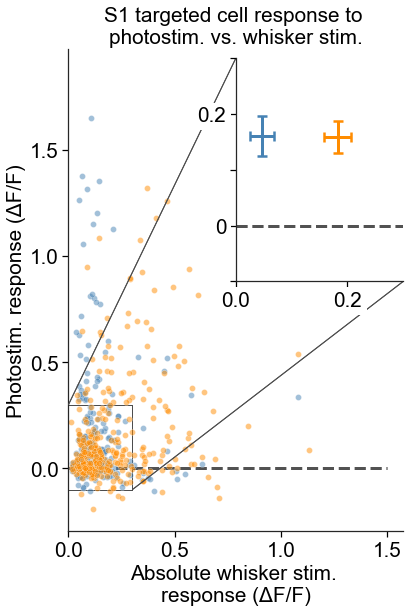

In [16]:
if sensory:
    
    trials = ['pr', 'ps']

    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6,12))

    for label, color, trial in zip(plot_labels, plot_colors, trials):
        target_df = cell_df.query(trial + '_target & sta_sig_whisker')
        
        
        
        photostim_mean_df = target_df[trial + '_sta_amp_resp'].mean()
        photostim_std_df = target_df[trial + '_sta_amp_resp'].std()
        photostim_95ci = 1.96*(photostim_std_df/np.sqrt(len(target_df)))
        whisker_mean_df = target_df['whisker_sta_amp_resp'].mean()
        whisker_std_df = target_df['whisker_sta_amp_resp'].std()
        whisker_95ci = 1.96*(whisker_std_df/np.sqrt(len(target_df)))
        
        # The data.
        sns.scatterplot(y=target_df[trial + '_sta_amp_resp'], x=np.absolute(target_df['whisker_sta_amp_resp']), 
                        alpha=0.5, ax=ax1, label=label, color=color)
    
        
        ax1.hlines(0, 0, 1.5, linestyle='--', zorder=-1, alpha=0.5, color='k', lw=3)
        ax1.set_aspect('equal')
        ax1.set_xlim([0,None])
        ax1.legend().set_visible(False)

        ax1.set_xlabel('Absolute whisker stim. \nresponse (ΔF/F)')
        ax1.set_ylabel('Photostim. response (ΔF/F)')
        ax1.set_title('S1 targeted cell response to \nphotostim. vs. whisker stim.', fontsize='xx-large', y=1)
        
        # Create a set of inset Axes: these should fill the bounding box allocated to
        # them.
        ax2 = plt.axes([0,0,1,1])
        # Manually set the position and relative size of the inset axes within ax1
        ip = InsetPosition(ax1, [0.5,0.5,0.5,0.5])
        ax2.set_axes_locator(ip)
        
        # Mark the region corresponding to the inset axes on ax1 and draw lines
        # in grey linking the two axes.
        pp = mark_inset(ax1, ax2, loc1=2, loc2=4, fc="none", ec='0.3', zorder=-1)
#         pp[1].set_visible(False)
#         pp[2].set_visible(False)
        
        # The data: only display for low temperature in the inset figure.
        ax2.errorbar(whisker_mean_df, photostim_mean_df,
                     yerr=photostim_95ci, xerr=whisker_95ci, elinewidth=plot_lw,
                     capsize=5, capthick=2.5, color=color)
        
        ax2.hlines(0, 0, 0.3, linestyle='--', zorder=-1, alpha=0.5, color='k', lw=3)
        ax2.set_aspect('equal')
        
        ax2.set_xlabel('')
        ax2.set_ylabel('')
        
        fig.canvas.draw()
        
        ax2.set_xticklabels(ax2.get_xticks(), backgroundcolor='w')
        ax2.set_yticklabels(['', '0', '', '0.2'], backgroundcolor='w')
        
        ax2.set_xlim([0, 0.3])
        ax2.set_ylim([-0.1, 0.3])
        
    # save the figure
    save_path = fig_save_path + '_target_cell_whisker_vs_photostim_response'
    ia.savePlot(save_path)

# Specific analyses for projection photostim. trial type

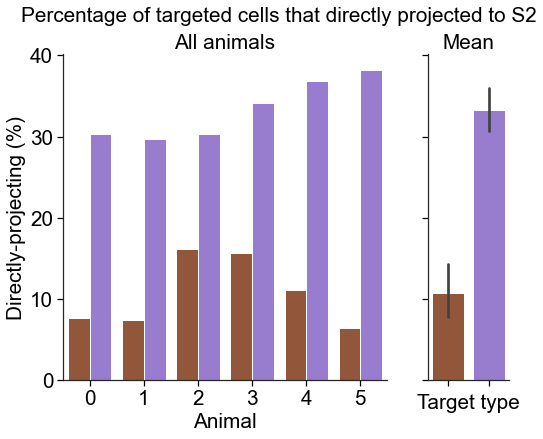

In [244]:
if projection:
    df = pd.DataFrame()
    
    unique_animals = len(cell_df.session_id.unique())
    
    targets = ['Non_projecting', 'Projecting']
    
    renamed_cell_df = cell_df.rename(columns = {'pr_target': 'Non_projecting', 'ps_target': 'Projecting'})

    for target in targets:
        target_df = renamed_cell_df.query(target)

        num_ctb_targets = target_df.groupby('session_id')['ctb_targets'].sum()
        num_targets = target_df.groupby('session_id')[target].count()

        percent_targets_ctb = num_ctb_targets/num_targets * 100
        session_labels = [session_id[-5:] for session_id in target_df['session_id'].unique()]

        temp_df = pd.DataFrame({'target_type' : np.repeat(target, len(percent_targets_ctb)),
                                'percent_ctb' : percent_targets_ctb,
                                'session_id' : session_labels
                               })

        df = pd.concat([df, temp_df])

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8,6), gridspec_kw={'width_ratios':(4, 1)})

    sns.barplot(data=df, x='session_id', y='percent_ctb', hue='target_type', palette=sns.color_palette(plot_colors), ax=axes[0]);
    sns.barplot(data=df, y='percent_ctb', x='target_type', palette=sns.color_palette(plot_colors), ax=axes[1]);

    for ax in axes:
        ax.set_ylabel('Directly-projecting (%)');

    axes[0].set_xlabel('Animal')
    axes[1].set_xlabel('Target type')

    axes[0].set_title('All animals')
    axes[1].set_title('Mean')
    
    axes[0].legend().set_visible(False)
    axes[1].set_ylabel('')
    
    ax0_labels = [item.get_text() for item in axes[0].get_xticklabels()]
    ax0_labels = list(range(0,unique_animals))

    axes[0].set_xticklabels(ax0_labels)
    
    ax1_labels = [item.get_text() for item in axes[1].get_xticklabels()]
    ax1_labels = ['','']

    axes[1].set_xticklabels(ax1_labels)
    
    plt.suptitle('Percentage of targeted cells that directly projected to S2', fontsize='xx-large', y=0.99);

    # save the figure
    save_path = fig_save_path + '_target_cell_group_ctb_labelling'
    ia.savePlot(save_path)

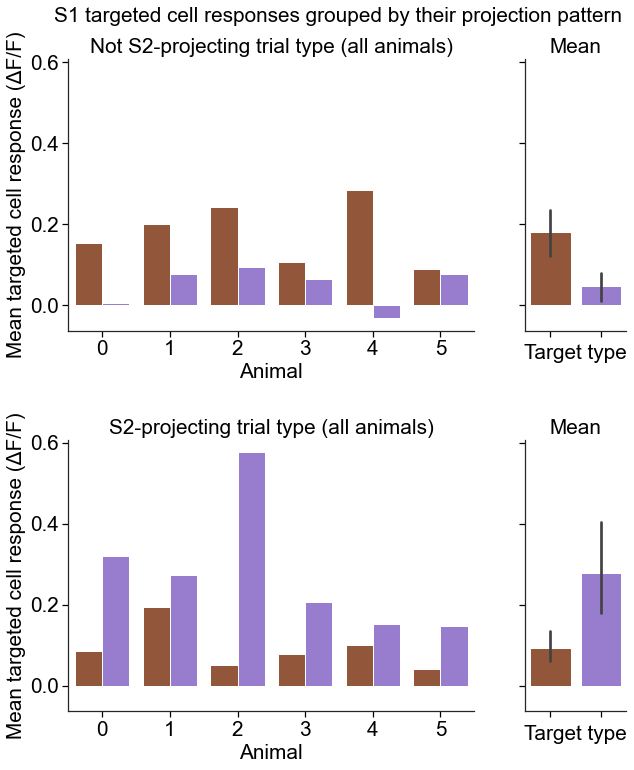

In [245]:
if projection:
    targets = ['Non_projecting', 'Projecting']
    labels = plot_labels[:2]
    trials = ['pr', 'ps']

    fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10,12), gridspec_kw={'width_ratios':(4,1)})
    
    renamed_cell_df = cell_df.rename(columns = {'pr_target': 'Non_projecting', 'ps_target': 'Projecting'})
    
    for i, (label, target, trial, ax) in enumerate(zip(labels, targets, trials, axes)):

        session_labels = []

        target_df = renamed_cell_df.query(target)

        ctb_negative_targets = target_df.query('~ctb_targets')
        sum_resp_ctb_negative = ctb_negative_targets.groupby('session_id').mean()[trial + '_sta_amp_resp']
        ctb_negative_labels = ctb_negative_targets.groupby('session_id').mean().index.to_numpy()
        
        ctb_positive_targets = target_df.query('ctb_targets')
        sum_resp_ctb_positive = ctb_positive_targets.groupby('session_id').mean()[trial + '_sta_amp_resp']
        ctb_positive_labels = ctb_positive_targets.groupby('session_id').mean().index.to_numpy()

    #     ctb_positive_filter = cell_mean_timepoint_df.cell_id.isin(ctb_positive_targets)
    #     ctb_positive_df = cell_mean_timepoint_df[ctb_positive_filter]

    #     ctb_negative_filter = cell_mean_timepoint_df.cell_id.isin(ctb_negative_targets)
    #     ctb_negative_df = cell_mean_timepoint_df[ctb_negative_filter]

        df = pd.DataFrame({'summed_resp' : np.hstack([sum_resp_ctb_negative, sum_resp_ctb_positive]),
                           'Target type' : np.hstack([np.repeat('Non_projecting', len(sum_resp_ctb_negative)), 
                                                      np.repeat('Projecting', len(sum_resp_ctb_positive))]),
                           'session_id' : np.hstack([ctb_negative_labels, ctb_positive_labels])
                          })
        
        sns.barplot(data=df, x='session_id', y='summed_resp', hue='Target type', 
                    palette=sns.color_palette(plot_colors), ax=ax[0])
        sns.barplot(data=df, y='summed_resp', x='Target type', 
                    palette=sns.color_palette(plot_colors), ax=ax[1])
    
        ax[0].set_title(label + ' trial type (all animals)')
        ax[0].set_ylabel('Mean targeted cell response (ΔF/F)')
        ax[0].set_xlabel('Animal')

        ax[1].set_ylabel('')
        ax[1].set_title('Mean')

        ax0_labels = [item.get_text() for item in ax[0].get_xticklabels()]
        ax0_labels = list(range(0,unique_animals))

        ax[0].set_xticklabels(ax0_labels)

        ax1_labels = [item.get_text() for item in ax[1].get_xticklabels()]
        ax1_labels = ['','']

        ax[1].set_xticklabels(ax1_labels)
        
        ax[0].legend().set_visible(False)

    plt.subplots_adjust(hspace=0.4)
    plt.suptitle('S1 targeted cell responses grouped by their projection pattern',
                fontsize='xx-large', y=0.94);

    # save the figure
    save_path = fig_save_path + '_target_cell_group_response_by_projection_type'
    ia.savePlot(save_path)

In [246]:
if projection:
    s2p_paths = session_df['s2p_path'].values
    session_ids = session_df.index.values

    whisker_responses = pd.Series(dtype='float64')

    for s2p_path, session_id in zip(s2p_paths, session_ids):

        tiff_folder = os.path.dirname(os.path.dirname(s2p_path))
        file_list = os.listdir(tiff_folder)

        for file in file_list:
            if 'whisker_response' in file:
                whisker_dff_img = tf.imread(os.path.join(tiff_folder, file))

        session_cell_df = cell_df[cell_df['session_id'] == session_id]

        cell_x_list = session_cell_df['cell_x'].values
        cell_y_list = session_cell_df['cell_y'].values
        cell_id_list = session_cell_df.index.values

        whisker_response = []

        for cell_x, cell_y in zip(cell_x_list, cell_y_list):

            whisker_response.append(np.mean(whisker_dff_img[cell_x, cell_y]))

        new_rows = pd.Series(data=whisker_response, index=cell_id_list)

        whisker_responses = whisker_responses.append(new_rows)

    cell_df['whisker_sta_amp_resp'] = whisker_responses

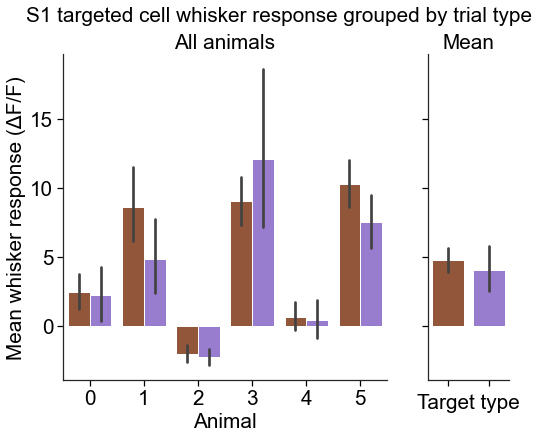

In [247]:
if projection:
    trial = 'whisker'

    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8,6), gridspec_kw={'width_ratios': (4,1)})
    
    renamed_cell_df = cell_df.rename(columns = {'pr_target': 'Non_projecting', 'ps_target': 'Projecting'}).copy()
    target_df = renamed_cell_df.query('Non_projecting | Projecting').copy()

    ctb_negative_targets = target_df.query('~ctb_targets').copy()
    mean_resp_ctb_negative = ctb_negative_targets[trial + '_sta_amp_resp']
    ctb_negative_labels = ctb_negative_targets.session_id.to_numpy()
    
    ctb_positive_targets = target_df.query('ctb_targets').copy()
    mean_resp_ctb_positive = ctb_positive_targets[trial + '_sta_amp_resp']
    ctb_positive_labels = ctb_positive_targets.session_id.to_numpy()

    df = pd.DataFrame({'mean_resp' : np.hstack([mean_resp_ctb_negative, mean_resp_ctb_positive]),
                       'Target_type' : np.hstack([np.repeat('Non-projecting', len(mean_resp_ctb_negative)), 
                                                  np.repeat('Projecting', len(mean_resp_ctb_positive))]),
                       'session_id' : np.hstack([ctb_negative_labels, ctb_positive_labels])
                      })

    sns.barplot(data=df, x='session_id', y='mean_resp', hue='Target_type', ci=95,
                palette=sns.color_palette(plot_colors), ax=ax[0])
    sns.barplot(data=df, x='Target_type', y='mean_resp', ci=95,
                palette=sns.color_palette(plot_colors), ax=ax[1])

    ax[0].set_ylabel('Mean whisker response (ΔF/F)')
    ax[0].set_xlabel('Animal')

    ax[1].set_ylabel('')
    ax[1].set_xlabel('Target type')
    
    ax[0].set_title('All animals')
    ax[1].set_title('Mean')
    
    ax0_labels = [item.get_text() for item in ax[0].get_xticklabels()]
    ax0_labels = list(range(0,unique_animals))

    ax[0].set_xticklabels(ax0_labels)

    ax1_labels = [item.get_text() for item in ax[1].get_xticklabels()]
    ax1_labels = ['','']

    ax[1].set_xticklabels(ax1_labels)
    
    ax[0].legend().set_visible(False)

    plt.suptitle('S1 targeted cell whisker response grouped by trial type',
                fontsize='xx-large', y=0.99);

    # save the figure
    save_path = fig_save_path + '_ResponseAmplitude_TargetCells_ProjectingS2_WhiskerResponse'
    ia.savePlot(save_path)

# Specific analyses for interneuron trial type

In [248]:
if interneuron:
    remove_id = '2021-01-28_RL124'
    cell_df = cell_df.query('session_id != @remove_id')
    cell_mean_timepoint_df = cell_mean_timepoint_df.query('session_id != @remove_id')

In [249]:
if interneuron:
    target_type = ['pr_target', 'pr_target']
    responses = ['pr_sta_resp', 'spont_sta_resp']

    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(12,6))

    n_numbers = []

    n_numbers.append(f'n = {len(cell_df["session_id"].unique())} animals')

    for label, target, response, color in zip(plot_labels, target_type, responses, plot_colors):

        # filter dataframes using variables above
        s1_targets = cell_df[cell_df[target] & cell_df['s1_cell']].index
        interneurons = cell_df[~cell_df[target] & cell_df['int_cell']].index
    #     interneurons = cell_df[cell_df['int_cell']].index

        # populate the plots with filtered data
        for col, cell_id_list in enumerate([s1_targets, 
    #                                         nontargets,
                                            interneurons
                                           ]):
            df_filter = cell_mean_timepoint_df['cell_id'].isin(cell_id_list)
            filtered_df = cell_mean_timepoint_df[df_filter].copy()
            filtered_df.loc[(filtered_df['timepoint'] > 0) & (filtered_df['timepoint'] <= photostim_duration), 
                    ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
            rolling_mean = filtered_df.groupby('cell_id').rolling(5, min_periods=1).mean()[response]
            
            ax = axes[col]
            sns.lineplot(data=filtered_df, x='timepoint', y=rolling_mean.to_numpy(), 
                         estimator='mean', ci=95, ax=ax, label=label, legend=False, color=color, linewidth=plot_lw)

            display(fig)
            clear_output(wait = True)

            target_text = ['targets', 'non targets']
            n_numbers.append(f'n = {len(cell_id_list.unique())} cells for {label} {target_text[col]}')

    # construct patch to cover stim artifact period
    for ax in axes:
        stim_patch = patches.Rectangle((0,-100), patch_size, 999, zorder=3, color=patch_color)
        ax.add_patch(stim_patch)

    axes[0].set_title('S1 target cells')
    # axes[1].set_title('S1 non-target cells')
    axes[1].set_title('Interneurons')

    for ax in axes:
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('')

    axes[0].set_ylabel('Response (ΔF/F)');
    axes[0].legend(plot_labels, loc='upper right');

    axes[0].hlines(0, -2, 10, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);
    axes[1].hlines(0, -2, 10, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);

    axes[0].set_ylim([-0.015, 0.20])
    axes[1].set_ylim([-0.015, 0.05])

    axes[1].set_xlim([-2, 6])

    plt.subplots_adjust(wspace=0.4)
    plt.suptitle('Grand average cell responses to photostimulation', fontsize='xx-large', y=1)

    print('N_numbers:', *n_numbers, sep='\n')

    save_path = fig_save_path + '_cell_grandaverage_dff_trace'
    ia.savePlot(save_path)

In [250]:
if interneuron:
    target_type = ['pr_target', 'pr_target']
    responses = ['pr_sta_resp', 'spont_sta_resp']

    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(12,6))

    n_numbers = []

    n_numbers.append(f'n = {len(cell_df["session_id"].unique())} animals')

    for label, target, response, color in zip(plot_labels, target_type, responses, plot_colors):

        # filter dataframes using variables above
        s1_targets = cell_df[cell_df[target] & cell_df['s1_cell']].index
        nontargets = cell_df[~cell_df[target] & cell_df['s1_cell']].index

        # populate the plots with filtered data
        for col, cell_id_list in enumerate([s1_targets, 
                                            nontargets,
    #                                         interneurons
                                           ]):
            df_filter = cell_mean_timepoint_df['cell_id'].isin(cell_id_list)
            filtered_df = cell_mean_timepoint_df[df_filter].copy()
            filtered_df.loc[(filtered_df['timepoint'] > 0) & (filtered_df['timepoint'] <= photostim_duration), 
                    ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
            rolling_mean = filtered_df.groupby('cell_id').rolling(5, min_periods=1).mean()[response]
            
            ax = axes[col]
            sns.lineplot(data=filtered_df, x='timepoint', y=rolling_mean.to_numpy(), 
                         estimator='mean', ci=95, ax=ax, label=label, legend=False, color=color, linewidth=plot_lw)

            display(fig)
            clear_output(wait = True)

            target_text = ['targets', 'non targets']
            n_numbers.append(f'n = {len(cell_id_list.unique())} cells for {label} {target_text[col]}')

    # construct patch to cover stim artifact period
    for ax in axes:
        stim_patch = patches.Rectangle((0,-100), patch_size, 999, zorder=3, color=patch_color)
        ax.add_patch(stim_patch)

    axes[0].set_title('S1 target cells')
    axes[1].set_title('S1 non-target cells')
    # axes[1].set_title('Interneurons')

    for ax in axes:
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('')

    axes[0].set_ylabel('Response (ΔF/F)');
    axes[0].legend(plot_labels, loc='upper right');

    axes[0].hlines(0, -2, 10, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);
    axes[1].hlines(0, -2, 10, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);

    axes[0].set_ylim([-0.015, 0.175])
    axes[1].set_ylim([-0.01, 0.04])

    axes[1].set_xlim([-2, 6])

    plt.subplots_adjust(wspace=0.4)
    plt.suptitle('Grand average cell responses to photostimulation', fontsize='xx-large', y=1)

    print('N_numbers:', *n_numbers, sep='\n')

    save_path = fig_save_path + '_cell_grandaverage_s1nt_dff_trace'
    ia.savePlot(save_path)

In [251]:
if interneuron:
    responses = ['pr_amp_resp', 'spont_amp_resp']
    targets = ['pr_target', 'pr_target']

    colors = plot_colors[:2]
    colors.append('k')

    # create and populate the plots using filtered data
    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(6,6))

    for response, target, label, color in zip(responses, targets, plot_labels, colors):

        int_cell_ids = cell_df.query('int_cell & ~' + target).index
        target_cell_ids = cell_df.query(target).index

        target_filter = cell_trial_df['cell_id'].isin(target_cell_ids)
        target_df = cell_trial_df[target_filter].dropna(axis=0, subset=[response])
        target_amp_resp = target_df.groupby(['trial_num','session_id']).sum()
        target_amp_resp = target_amp_resp.groupby('session_id').transform(lambda x : stats.zscore(x, ddof=1))[response]

        int_filter = cell_trial_df['cell_id'].isin(int_cell_ids)
        int_df = cell_trial_df[int_filter].dropna(axis=0, subset=[response])
        int_amp_resp = int_df.groupby(['trial_num','session_id']).sum()
        int_amp_resp = int_amp_resp.groupby('session_id').transform(lambda x : stats.zscore(x, ddof=1))[response]

        df = pd.DataFrame({'target_amp_resp' : target_amp_resp,
                           'int_amp_resp'     : int_amp_resp})

        df = df.reset_index(drop=False)

        sns.regplot(x=df['target_amp_resp'], y=df['int_amp_resp'], 
                data=df, ax=axes, label=label, color=color)

        axes.set_ylabel('Z-scored summed int. activity')
        axes.legend()
        axes.set_xlabel('Z-scored summed target activity')

        axes.set_aspect('equal')

        slope, _, r_value, p_value, _ = stats.linregress(x=df['target_amp_resp'], 
                                                         y=df['int_amp_resp'])
        print('trial:', label,
              'slope', slope,
              'r_value', r_value,
              'p_value', p_value
             )

    plt.suptitle('Trial-wise target vs. interneuron activity', y=0.95, 
             fontsize='xx-large');

    # save the figure
    save_path = fig_save_path + '_target_int_activity_correlation_trialwise_zscore'
    ia.savePlot(save_path)

In [252]:
if interneuron:
    responses = ['pr', 'spont']
    targets = ['pr_target', 'pr_target']

    colors = plot_colors[:2]
    colors.append('k')

    # create and populate the plots using filtered data
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6,12))

    for response, target, label, color in zip(responses, targets, plot_labels, colors):

        int_df = cell_df.query('int_cell & s1_cell & ~' + target)

        int_resp = int_df[response + '_sta_amp_resp'].values.astype('float')
        int_dist = int_df.dist_to_targ.values.astype('float')

        mean_dist, bin_edges, bin_nums = stats.binned_statistic(int_dist, int_dist, statistic=np.nanmean, bins=15, range=(0,750))
        bin_nums[np.where(bin_nums==16)[0]] = 15

        count, hist_bins = np.histogram(int_dist, bin_edges)

        sns.lineplot(x=mean_dist[bin_nums-1], y=int_resp, ax=axes[0], ci=95, label=label, color=color, lw=plot_lw)
    #     sns.regplot(x=int_dist, y=int_resp, ax=axes, label=label, color=color)

        axes[0].set_ylabel('Interneuron response (ΔF/F)')
        axes[0].legend()
        axes[0].set_xlabel('Distance to nearest target')

        axes[0].hlines(0, -3, 550, linestyles='dotted', zorder=-1, alpha=0.5, lw=3, color='k');
        axes[1].set_xlim([0,350])

        slope, _, r_value, p_value, _ = stats.linregress(x=int_dist, y=int_resp)
        print('trial:', label,
              'slope', slope,
              'r_value', r_value,
              'p_value', p_value
             )

    sns.histplot(x=mean_dist[bin_nums-1], ax=axes[1], color='k')
    axes[1].set_xlabel('Distance to nearest target (μm)')
    axes[1].set_ylabel('# cells')

    plt.subplots_adjust(hspace=0.1)
    plt.suptitle('Interneuron activity vs. distance to target', y=0.91, 
             fontsize='xx-large');

    # save the figure
    save_path = fig_save_path + '_target_int_activity_correlation_dist_to_targ'
    ia.savePlot(save_path)

In [253]:
if interneuron:
    # list of column names to be used to filter the dataframe
    target_type = ['pr_target', 'pr_target']
    responses = ['pr_sta_resp', 'spont_sta_resp']

    n_numbers = []

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(12,6))

    for target, response, color, label, ax in zip(target_type, responses, plot_colors, plot_labels, axes):

        # filter dataframes using variables above
        interneurons = cell_df[~cell_df[target] & cell_df['int_cell'] & cell_df['s1_cell']].index

        df_filter = cell_mean_timepoint_df['cell_id'].isin(interneurons)
        filtered_df = cell_mean_timepoint_df[df_filter]

        for session_id in filtered_df.session_id.unique():
            animal_df = filtered_df.loc[filtered_df.session_id == session_id].copy()
            animal_df.loc[(animal_df['timepoint'] > 0) & (animal_df['timepoint'] <= photostim_duration), 
                    ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
            rolling_mean = animal_df.groupby('cell_id').rolling(5, min_periods=1).mean()[response]

            sns.lineplot(data=animal_df, x='timepoint', y=rolling_mean.to_numpy(), 
                         estimator='mean', ci=95, ax=ax, color=color, linewidth=plot_lw)

        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Response (ΔF/F)')
        ax.set_title(label)
        ax.hlines(0, -3, 11, linestyles='dotted', zorder=4, alpha=0.5, lw=3, color='k');
    #     ax.set_ylim([-0.03, 0.2])
        ax.set_ylim([-0.03, 0.05])
        ax.set_xlim([-2,6])

        # construct patch to cover stim artifact period
        stim_patch = patches.Rectangle((0,-100), patch_size, 999, zorder=3, color=patch_color)
        ax.add_patch(stim_patch)

        target_text = ['targets', 'non targets']
        n_numbers.append(f'n = {len(interneurons.unique())} cells for {label} non-targets')

        display(fig)
        clear_output(wait = True)

    for ax in axes[1:3]:
        ax.set_ylabel('')

    plt.suptitle('Animal-wise average interneuron responses to photostimulation', fontsize='xx-large', y=1)
    save_path = fig_save_path + '_cell_grandaverage_dff_trace_animalwise'
    ia.savePlot(save_path)

    n_numbers.append(f'n = {len(cell_df["session_id"].unique())} animals')

    print('N_numbers:', *n_numbers, sep='\n')